# 1. Import Libraries

In [649]:
# Import libraries for data preparation and analysis
import numpy as np
import statistics as stat
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import statistical tests
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.feature_selection import mutual_info_regression
from numpy import log

# Import normalisation algorithms
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Import feature selection algorithm
from sklearn.decomposition import PCA

# Import algorithm to split dataset
from sklearn.model_selection import train_test_split

# Import algorithms for cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Import modelling algorithms
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Import evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error as MAPE

# Import hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Import advanced neural networks 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Import SHAP Analysis module
import shap

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# 2. Define Functions

In [651]:
# Determine if any missing values in dataset
def find_missing_values(dataset):
    """ This function determines if there are missing data in a dataset and returns a list of the affected attributes
    and number of missing values."""
    _ = dataset.isnull().sum()
    missing_values = _[_ > 0]
    return missing_values

In [652]:
def model_selection(exclude_model: list, *params):
    """This function adds a wide range of different algorithms primed with specified hyperparameters to a list of models."""
    
    # Create list of models
    models = []
    
    # Add algorithm to list of models
    models.append(("SVR", SVR(**svr_params)))
    models.append(("RFR", RandomForestRegressor(**rfr_params)))
    models.append(("GBR", GradientBoostingRegressor(**gbr_params)))
    models.append(("XGB", XGBRegressor(**xgb_params)))
    return models

In [653]:
def split_dataset(X, y, test_split: float):
    """This function splits a dataset into training and test sets depending upon specified test split fraction."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=1, shuffle=True)
    return X_train, X_test, y_train, y_test, test_split

In [654]:
def find_best_worst_model(names: list, MAE_results: list):
    """This function is used to determine the best performing and worst performed trained model \
    on the basis of mean absolute error score."""
    # Create zipped object (names, results)
    model_result = list(zip(names, MAE_results))

    # Find the best performing model 
    best_model = max(model_result, key=lambda x: x[1].mean())

    # Find the worst performing model
    non_best_model = min(model_result, key=lambda x: x[1].mean())

    # Sort model results in descending order
    model_result.sort(key=lambda x: x[1].mean(), reverse=True)

    print(f"Best performing model: {best_model[0]}")
    print(f"Worst performing model: {non_best_model[0]}")
    print("\r")

    print(f"{len(names)} best performing models")
    print("-" * 27)
    for idx, t in enumerate(model_result[:5], start=1):
        print(f"\t{idx}. -> {t[0]}")
    print("\r")

In [655]:
def plot_cv_scores(MAE_results: list, test_split_fraction: float):
    """This function generates a sequence of boxplots to evaluate trained model performance."""
    # Set plot size
    plt.figure(figsize=(6,4))

    # Plot accuracy scores using boxplots for specified test split
    plt.boxplot(results, labels=names)
    plt.title(f"{test_split_fraction*100}% Test Split: Model Comparision", fontsize=16)
    plt.show()

In [656]:
def APE(actual_value: float, predicted_value: float):
    """This function is used to calculate the absolute percentage error between an actual value and a predicted value."""
    ape = np.abs((actual_value - predicted_value)/actual_value)*100
    return ape[0]

In [657]:
def make_prediction_manuf_sales(model, inputs: list, actual_target: int):
    """This function is used to make a prediction about US manufacturers' sales and calculates the percentage error \
    when predicted value is compared against actual target data."""
    predicted_manuf_sales = model.predict([inputs])
    
    # Define actual manufacturers' sales for specific month
    actual_manuf_sales = actual_target
    
    # Compare prediction with actual manufacturers' sales for August 2024
    print(f"Predicted US Manufacturers' Sales: USD ${predicted_manuf_sales[0]:.2f}")
    print(f"Actual US Manufacturers' Sales: USD ${actual_manuf_sales:.2f}" if actual_manuf_sales > 0 else "No data available.")
    print(f"Absolute Percentage Error: {APE(actual_manuf_sales, predicted_manuf_sales):.2f}%" if actual_manuf_sales > 0 else "")

In [658]:
def extract_data(data, start_date: str, end_date: str):
    """ This function extracts rows from a dataframe for a specified date range (yyyy-dd-mm)."""
    extr = df[(df["Date"].astype(str) >= start_date) & (df["Date"].astype(str) < end_date)]
    return extr

In [659]:
def compile_data(stored_data, month, pred_value, actual_value):
    """This function is used to collate relevant data (month, prediction, actual sales) about US manufacturers' sales. \
    The data is stored as a dictionary."""
    if "month" in stored_data:
        stored_data["month"].append(month)

    if "pred_value" in stored_data:
        stored_data["pred_value"].append(pred_value)

    if "actual_value" in stored_data and actual_value > 0:
        stored_data["actual_value"].append(actual_value)
    else:
        # If actual value is not known, predicted value is used as a substitute
        stored_data["actual_value"].append(pred_value)

In [660]:
def model_pred_actual(best_model, stored_data: dict, month: str, inputs: list, actual_manuf_sales: float):
    """ This function uses a tuned model to make a prediction using a list of input variables and then calculates \
    the percentage error of the prediction when compared against the corresponding actual data. """
    # Make prediction
    predicted_manuf_sales = best_model.predict([inputs])

    # Make prediction and calculate percentage error
    make_prediction_manuf_sales(best_model, inputs, actual_manuf_sales)

    # Store data in dictionary
    compile_data(stored_data, month, predicted_manuf_sales[0], actual_manuf_sales)

In [661]:
def test_stationarity(data_series, data_name: str, log_curve: bool):
    """ This function is used to apply the Augmented Dickey-Fuller Test (ADF) and KPSS Test to ascertain if a time series is \
    stationary or non-stationary. """
    X, title = data_series, data_name

    # Treat data with log function
    if log_curve is True:
        X = log(X)

    # Run statistical tests
    adf_result = adfuller(X, autolag="AIC")
    kpss_result = kpss(X, regression="c")

    print(f"{data_name}")
    print("-" * len(data_name))

    # ADF Test
    print(f"ADF Statistic: {adf_result[0]:.3f}")
    print(f"p-value: {adf_result[1]:.3f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value}")

    print("\r")
    # Null hypothesis: Plot is unit root (or non-stationary) # Alternative hypothesis (p < 0.05): Plot is stationary
    print("ADF Test Result: Non-stationary time series" if adf_result[1] > 0.05 else "ADF Test Result: Stationary time series")
    print("\r")

    # KPSS Test
    print(f"KPSS Statistic: {kpss_result[0]:.3f}")
    print(f"p-value: {kpss_result[1]:.3f}")
    print(f"Lags used: {kpss_result[2]}")
    print("Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"\t{key}: {value}")

    print("\r")
    # Null hypothesis: Plot is stationary # Alternative hypothesis (p < 0.05): Plot is unit root (non-stationary)
    print("KPSS Test Result: Stationary time series" if kpss_result[1] > 0.05 else "KPSS Test Result: Non-stationary time series")
    print("--" * 25)
    print("\r")

    # Create plot 
    fig, ax = plt.subplots(figsize=(6,4))
    color = "tab:blue"
    plt.title(title, fontsize=16, fontweight="bold")
    plt.xlabel("Date (months)", fontsize=10)
    plt.plot(X, color=color)
    plt.show()
    print("\r\r")

In [662]:
def detrend_data(data_series, log_curve: bool):
    """ Detrend data series by calculating difference between the nth observation and n-1 observation. """
    if log_curve is True:
        # Calculate logarithm of data_series
        df["_log"] = np.log(df[data_series])
        # Difference nth observation and n-1 observation
        df["diff"] = df["_log"] - df["_log"].shift(1)
    else:
        df["diff"] = df[data_series] - df[data_series].shift(1)
    # Delete missing values
    g = df["diff"].dropna(axis=0)
    return g

# 3. Import Dataset

In [664]:
# Import consolidated FRED dataset
df = pd.read_csv("Consolidated FRED Source Dataset.csv")

In [665]:
# Preview of dataset
df.tail(5)

Date  US Credit Card Rates (%)      Date.1  Crude Oil Prices USA  \
684  01/02/2024                     21.59  01/02/2024                 77.25   
685  01/03/2024                       NaN  01/03/2024                 81.28   
686  01/04/2024                       NaN  01/04/2024                 85.35   
687  01/05/2024                     21.51  01/05/2024                 80.02   
688  01/06/2024                       NaN  01/06/2024                 79.77   

         Date.2  Brent Crude Prices Europe      Date.3  Global LNG Price  \
684  01/02/2024                      83.48  01/02/2024           8.82225   
685  01/03/2024                      85.41  01/03/2024           8.99325   
686  01/04/2024                      89.94  01/04/2024           9.79400   
687  01/05/2024                      81.75  01/05/2024          10.84700   
688  01/06/2024                      82.25  01/06/2024          12.36800   

         Date.4  Flexible Price CPI % Change      Date.5  \
684  01/02/2024                     1.439474  01/02/2024   
685  01/03/2024                     2.180211  01/03/2024   
686  01/04/2024                     4.469153  01/04/2024   
687  01/05/2024                    -0.625906  01/05/2024   
688  01/06/2024                    -4.572186  01/06/2024   

     Gold (USD per 100 kg)      Date.6  Iron Ore (USD per metric tonne)  \
684                  710.1  01/02/2024                       125.928571   
685                  748.9  01/03/2024                       110.190476   
686                  796.9  01/04/2024                       112.227273   
687                  806.9  01/05/2024                       119.239130   
688                  817.5  01/06/2024                       108.100000   

         Date.7  Copper (USD per metric tonne)      Date.8  \
684  01/02/2024                    8304.950476  01/02/2024   
685  01/03/2024                    8692.819048  01/03/2024   
686  01/04/2024                    9445.593636  01/04/2024   
687  01/05/2024                   10117.163480  01/05/2024   
688  01/06/2024                    9648.167000  01/06/2024   

     Actual Manufacturer's Sales (USD, millions)      Date.9  Future M-Sales  
684                                     556503.0  01/03/2024        606486.0  
685                                     606486.0  01/04/2024        589418.0  
686                                     589418.0  01/05/2024        601302.0  
687                                     601302.0  01/06/2024        608246.0  
688                                     608246.0  01/07/2024        578946.0

# 4. Exploratory Data Analysis 

### View dimensions of dataset

In [668]:
# Determine number of rows and columns in imported dataset
df.shape

(689, 20)

### View summary of dataset

In [670]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 20 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Date                                         356 non-null    object 
 1   US Credit Card Rates (%)                     119 non-null    float64
 2   Date.1                                       462 non-null    object 
 3   Crude Oil Prices USA                         462 non-null    float64
 4   Date.2                                       446 non-null    object 
 5   Brent Crude Prices Europe                    446 non-null    float64
 6   Date.3                                       390 non-null    object 
 7   Global LNG Price                             390 non-null    float64
 8   Date.4                                       689 non-null    object 
 9   Flexible Price CPI % Change                  356 non-null    float64
 10  Da

In [671]:
# Generate list of columns
col_list = df.columns.to_list()

# Generate list of date columns
dates = [col for col in col_list if "Date" in col]

# Convert object data types to date
for date in dates:
    df[date] = pd.to_datetime(df[date]).dt.date

### Truncate dataset to specific date range

In [673]:
# Exclude data before 1st November 1994
data = df[df.Date.notnull()]

### Remove extraneous dimensions

In [675]:
# Drop extraneous date columns
for date_col in dates[1:-1]:
    try:
        del data[date_col]
    except Exception as e:
        print(f"{e}: No data")

### Rename selected dimensions

In [677]:
# Rename "Date.6" and "Actual Manufacturers' Sales" columns
data.rename(columns={"Date.6": "Future Date", "Actual Manufacturer's Sales (USD, millions)": "Manu Sales (USD, millions)"}, inplace=True)

### Checking for missing values

In [679]:
# Find missing values within dataset
find_missing_values(data)

US Credit Card Rates (%)    237
dtype: int64

In [680]:
# Fill missing data with previous row values
data.fillna(method="pad", inplace=True)

### Preview of truncated dataset

In [682]:
# Generate list of dataframe columns
cols_list = data.columns.to_list()

# Generate dataframe excluding last two dimensions, "Future Date" and "Future M-Sales"
df = data.loc[:, data.columns.isin(cols_list[:-2])]
df.head()

Date  US Credit Card Rates (%)  Crude Oil Prices USA  \
333  1994-01-11                     15.69                 18.07   
334  1994-01-12                     15.69                 17.16   
335  1995-01-01                     15.69                 18.04   
336  1995-01-02                     16.10                 18.57   
337  1995-01-03                     16.10                 18.54   

     Brent Crude Prices Europe  Global LNG Price  Flexible Price CPI % Change  \
333                      17.19              3.25                     0.244362   
334                      15.93              3.23                     1.678814   
335                      16.55              3.38                     2.052855   
336                      17.11              3.54                     2.093692   
337                      17.01              3.80                     0.018245   

     Gold (USD per 100 kg)  Iron Ore (USD per metric tonne)  \
333                  138.9                            11.45   
334                  136.8                            11.45   
335                  135.9                            12.27   
336                  136.1                            12.27   
337                  135.9                            12.27   

     Copper (USD per metric tonne)  Manu Sales (USD, millions)  
333                    2803.545411                    280455.0  
334                    2980.699996                    279888.0  
335                    3003.261895                    260175.0  
336                    2870.450158                    286290.0  
337                    2919.673978                    303201.0

In [683]:
# Determine number of rows and columns in truncated dataset
df.shape

(356, 10)

### Normalisation of Dataset For Comparison Purposes

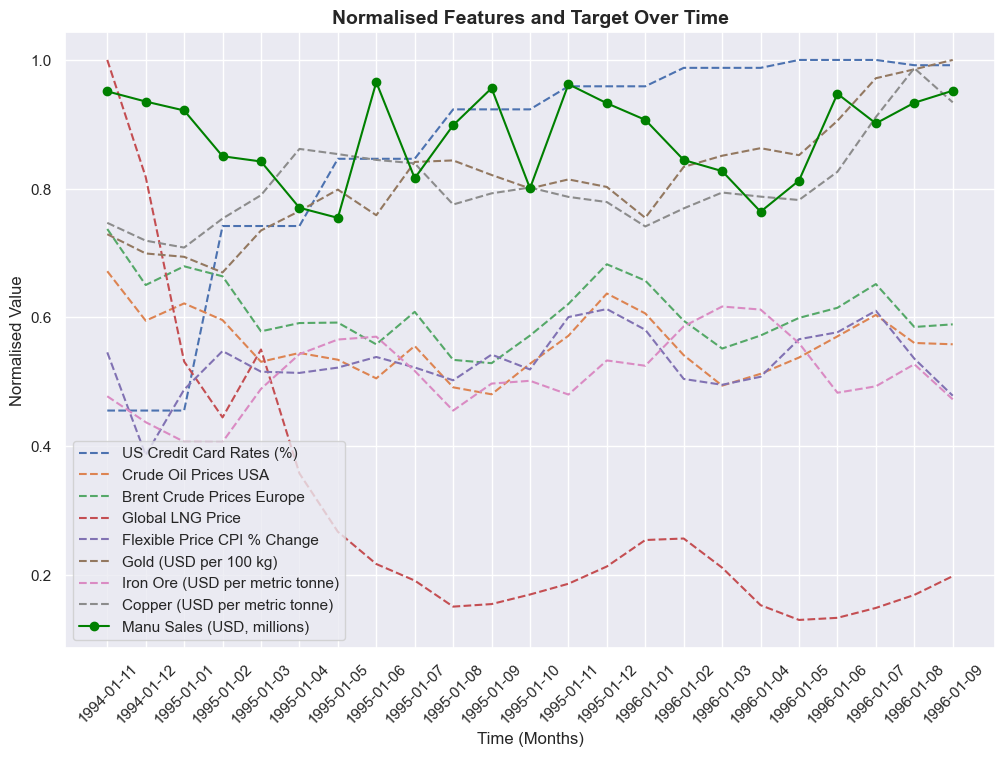

In [685]:
# Copy data frame
df_duplicate = df.copy()

# Remove date column from dataset
date_column = df_duplicate["Date"]
df_numerical = df_duplicate.drop(columns=["Date"])

# Set up scaler object
scaler = MinMaxScaler()

# Normalise dataset using the scaler object
scaled_data = scaler.fit_transform(df_numerical)

# Create data frame using normalised data and re-attach original "Date" column
scaled_df = pd.DataFrame(scaled_data, columns=df_numerical.columns)
scaled_df["Date"] = date_column

# Filter dataset for dates starting from "1994-01-11"
scaled_df["Date"] = pd.to_datetime(scaled_df["Date"])
scaled_df = scaled_df[scaled_df["Date"] >= "1994-01-11"]

# Convert "Date" column to string format
scaled_df["Date"] = scaled_df["Date"].astype(str)

# Drop any "NAN" values from dataset
scaled_df.dropna(axis=1, inplace=True)

# Define figure to display normalised data
plt.figure(figsize=(12,8))
plt.title("Normalised Features and Target Over Time", fontsize=14, fontweight="bold")
plt.xlabel("Time (Months)")
plt.ylabel("Normalised Value")

for column in df_numerical.columns:
    if column == "Manu Sales (USD, millions)":
        plt.plot(scaled_df["Date"], scaled_df[column], label=column, marker="o", color="green")
    else:
        plt.plot(scaled_df["Date"], scaled_df[column], label=column, ls="--")
    
# Display normalised data with legend for interpretability
plt.legend(loc="best")
plt.xticks(rotation=45)
plt.show();

### Pair plots

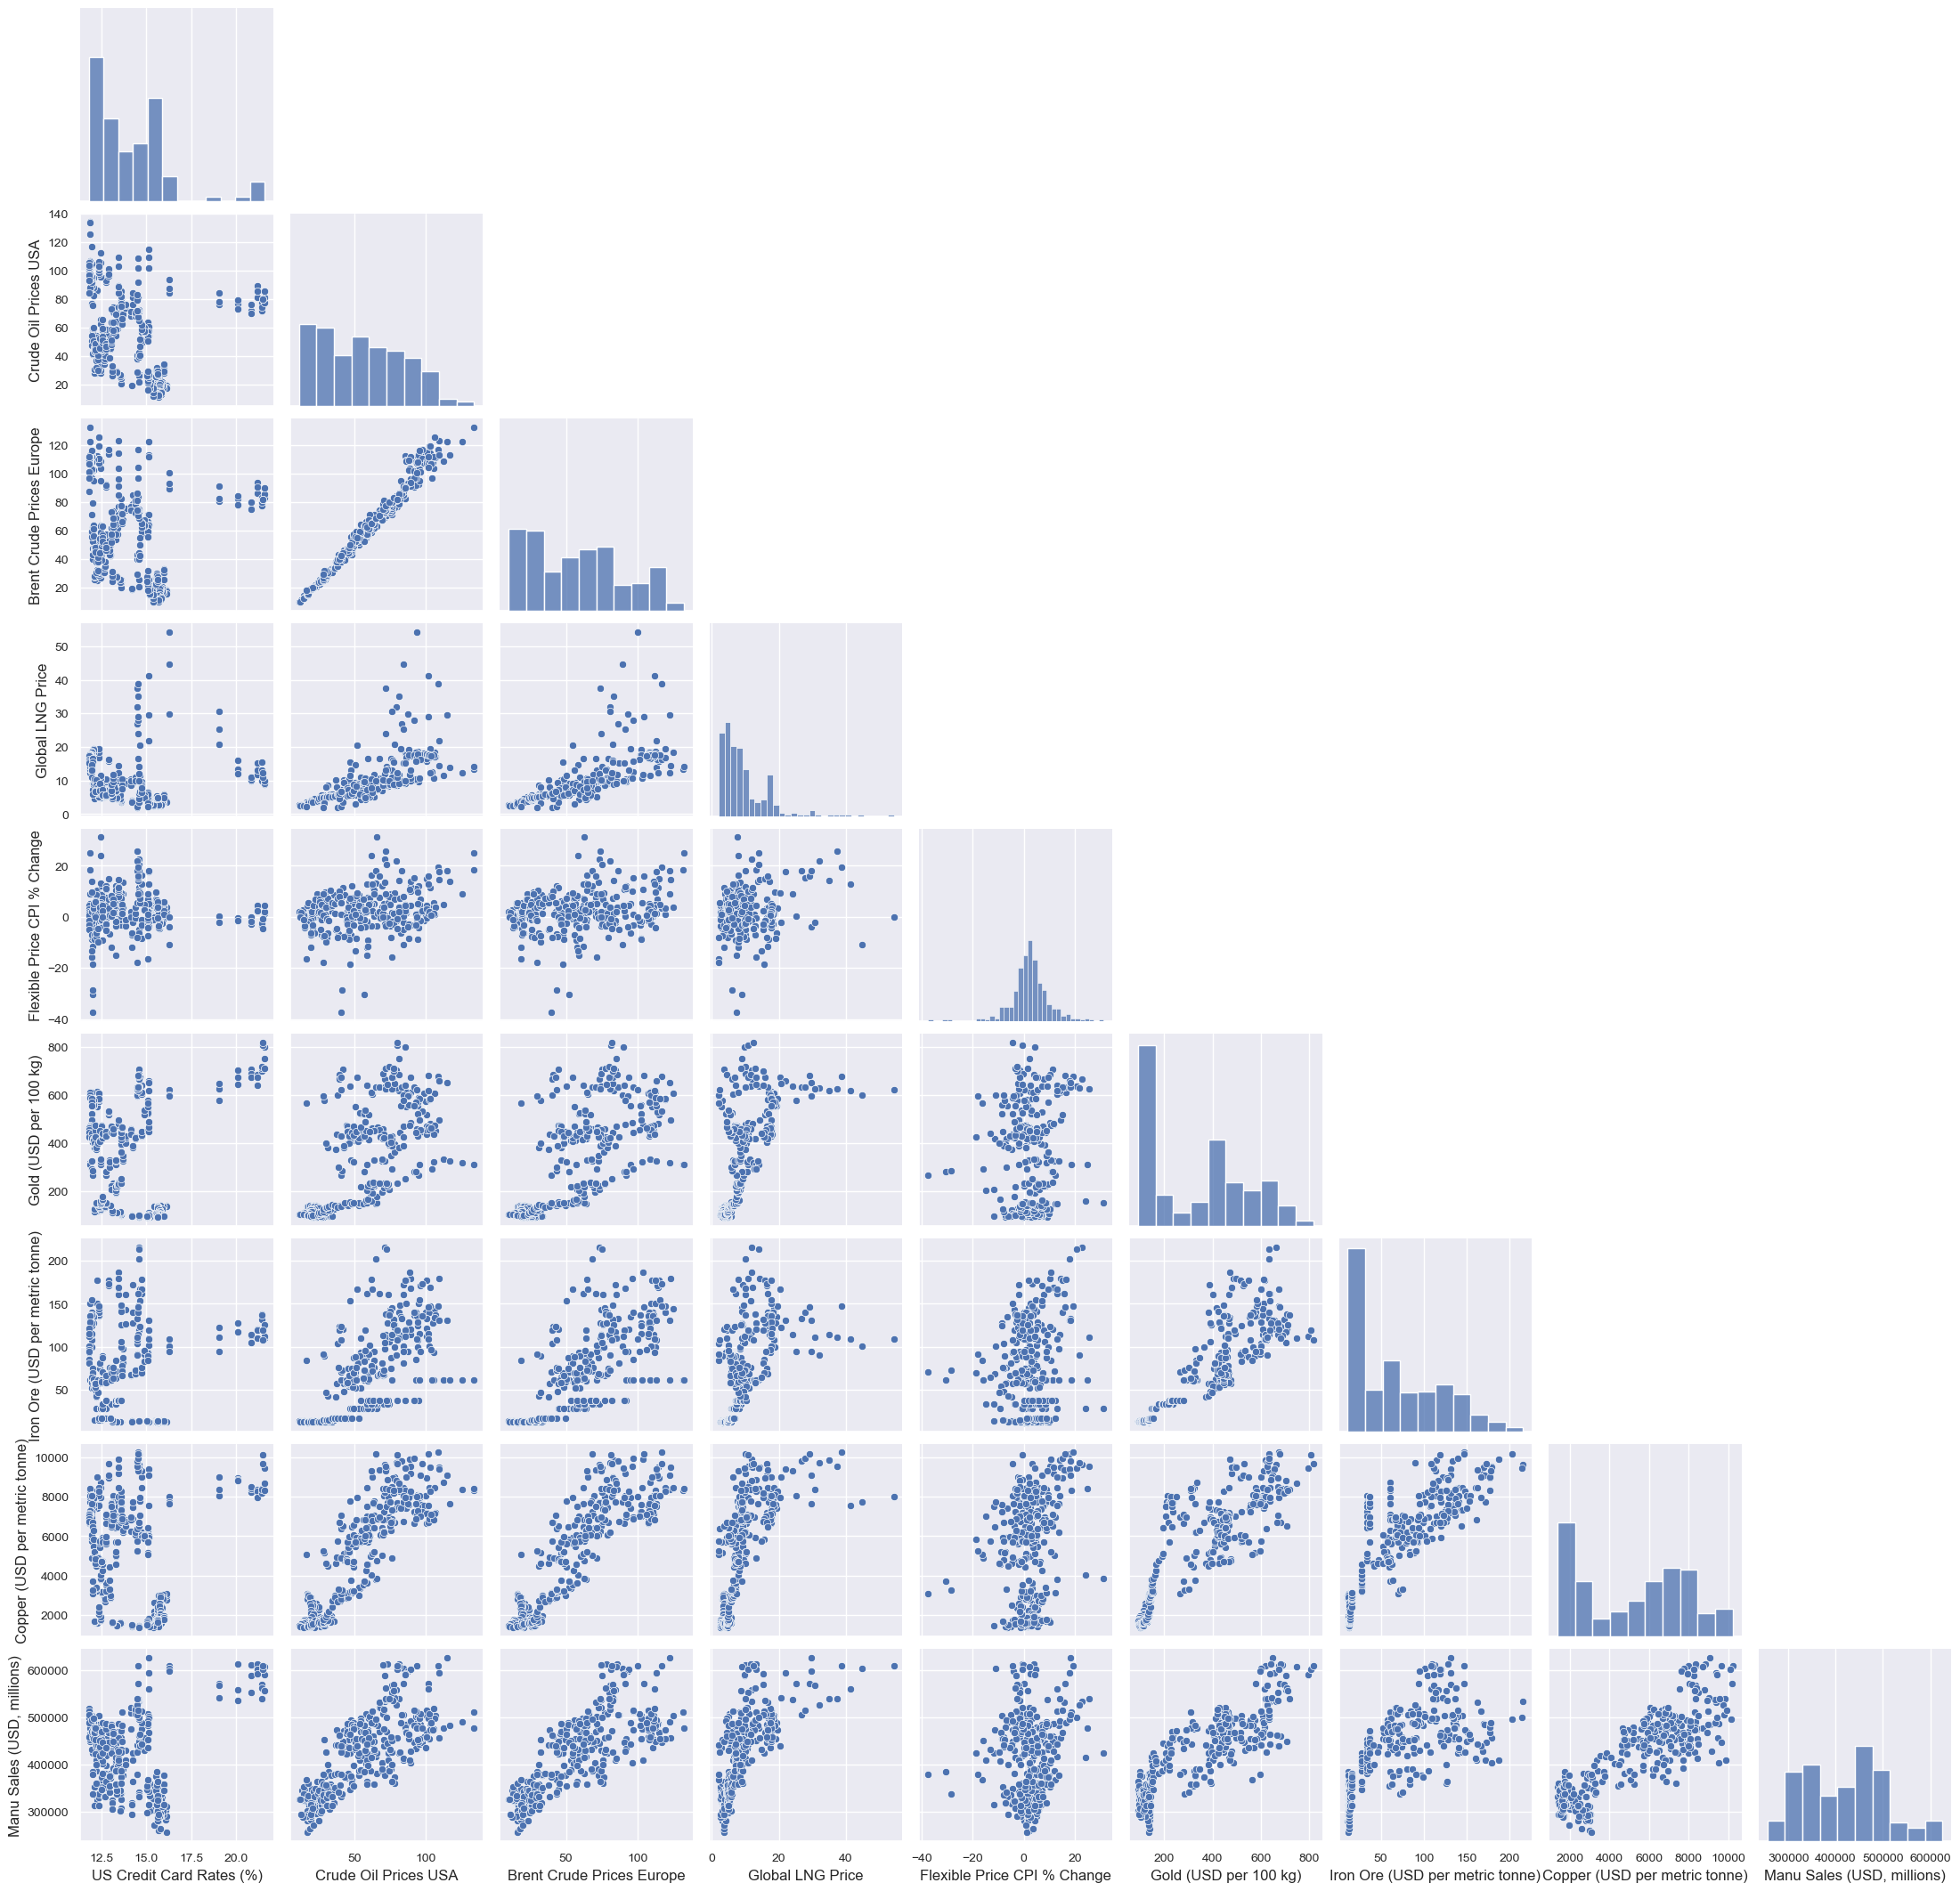

In [687]:
# Set figure size
sns.set(rc={"figure.figsize":(3,4)})

# Create pair plots
g = sns.pairplot(df, corner=True)

# Adjust label sizes
g.fig.subplots_adjust(top=0.95)

for ax in g.axes.flatten():
    if ax is not None:
        ax.tick_params(labelsize=10)

plt.show()

### Scatter Plots

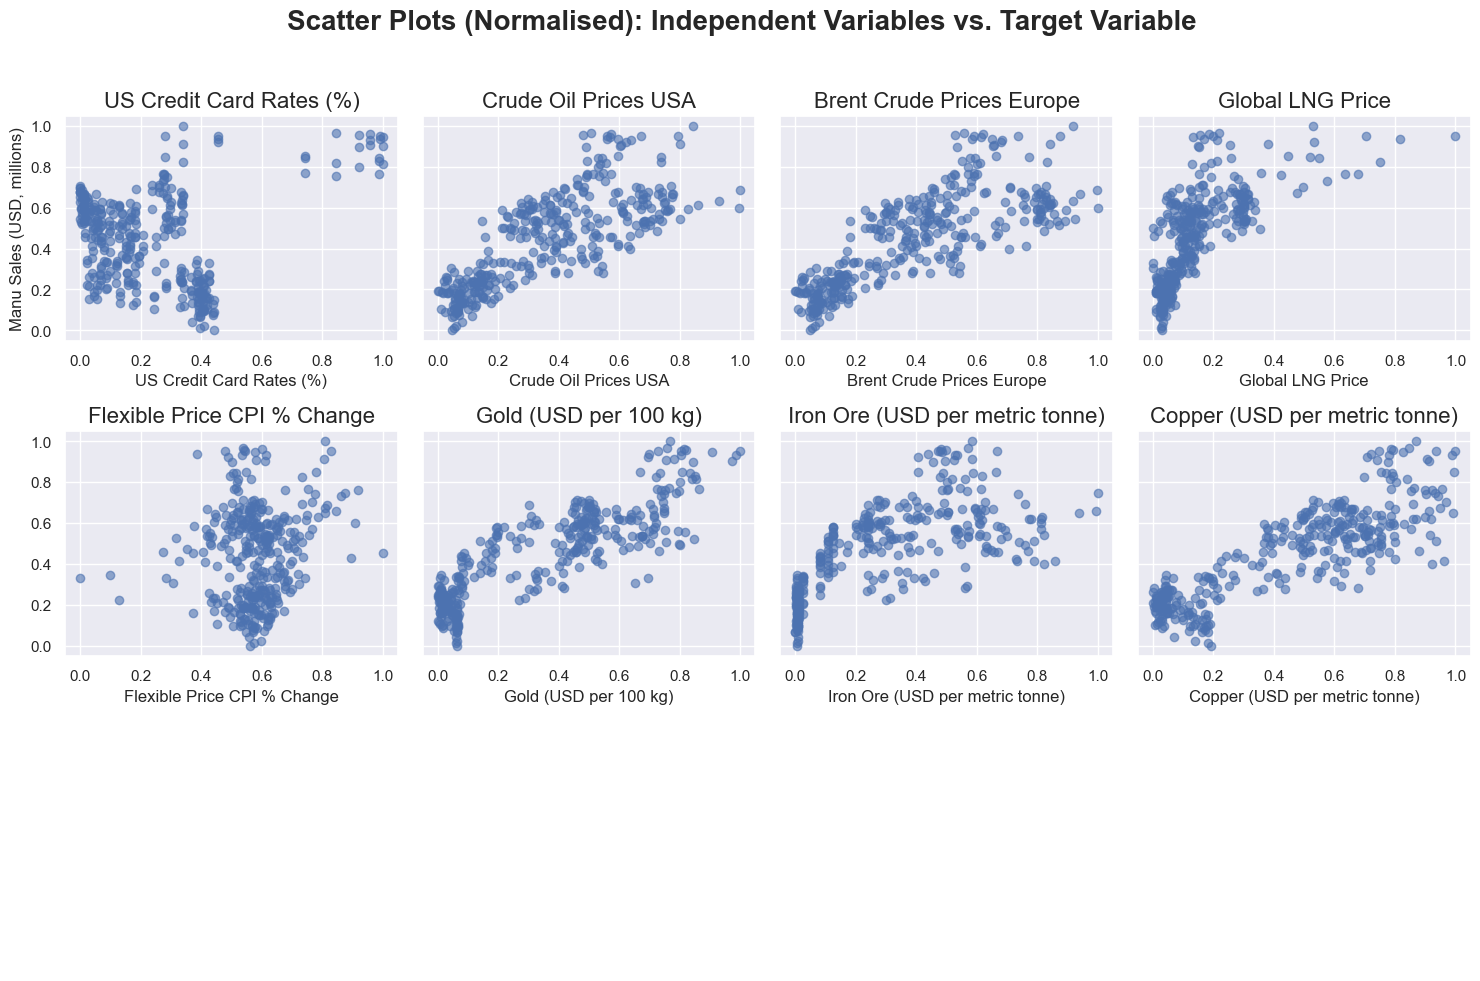

In [689]:
# Create duplicate of dataset
_df = df.copy()

# Drop "Date" column 
_df = _df.drop("Date", axis=1)

# Normalising all features in dataset using MinMaxScaler
scaler = MinMaxScaler()
normalised_data = pd.DataFrame(scaler.fit_transform(_df), columns=_df.columns)

# Define input variables and target variable
input_variables = normalised_data.columns.to_list()[:-1]
target_variable = normalised_data.columns.to_list()[-1]

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=(len(input_variables) // 2 + len(input_variables) % 2), figsize=(15,10), sharey=True)
fig.suptitle("Scatter Plots (Normalised): Independent Variables vs. Target Variable", fontsize=20, fontweight="bold")

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Generate scatter plots for each input variable
for i, input_var in enumerate(input_variables):
    axes[i].scatter(normalised_data[input_var], normalised_data[target_variable], alpha=0.6, color="b")
    axes[i].set_title(input_var, fontsize=16)
    axes[i].set_xlabel(input_var, fontsize=12)
    axes[i].set_ylabel(target_variable if i == 0 else "", fontsize=12)

# Hide any unused subplots
for sp in range(len(input_variables), len(axes)):
    axes[sp].axis("off")

# Adjust layout to fit title
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### 6-month moving average plots

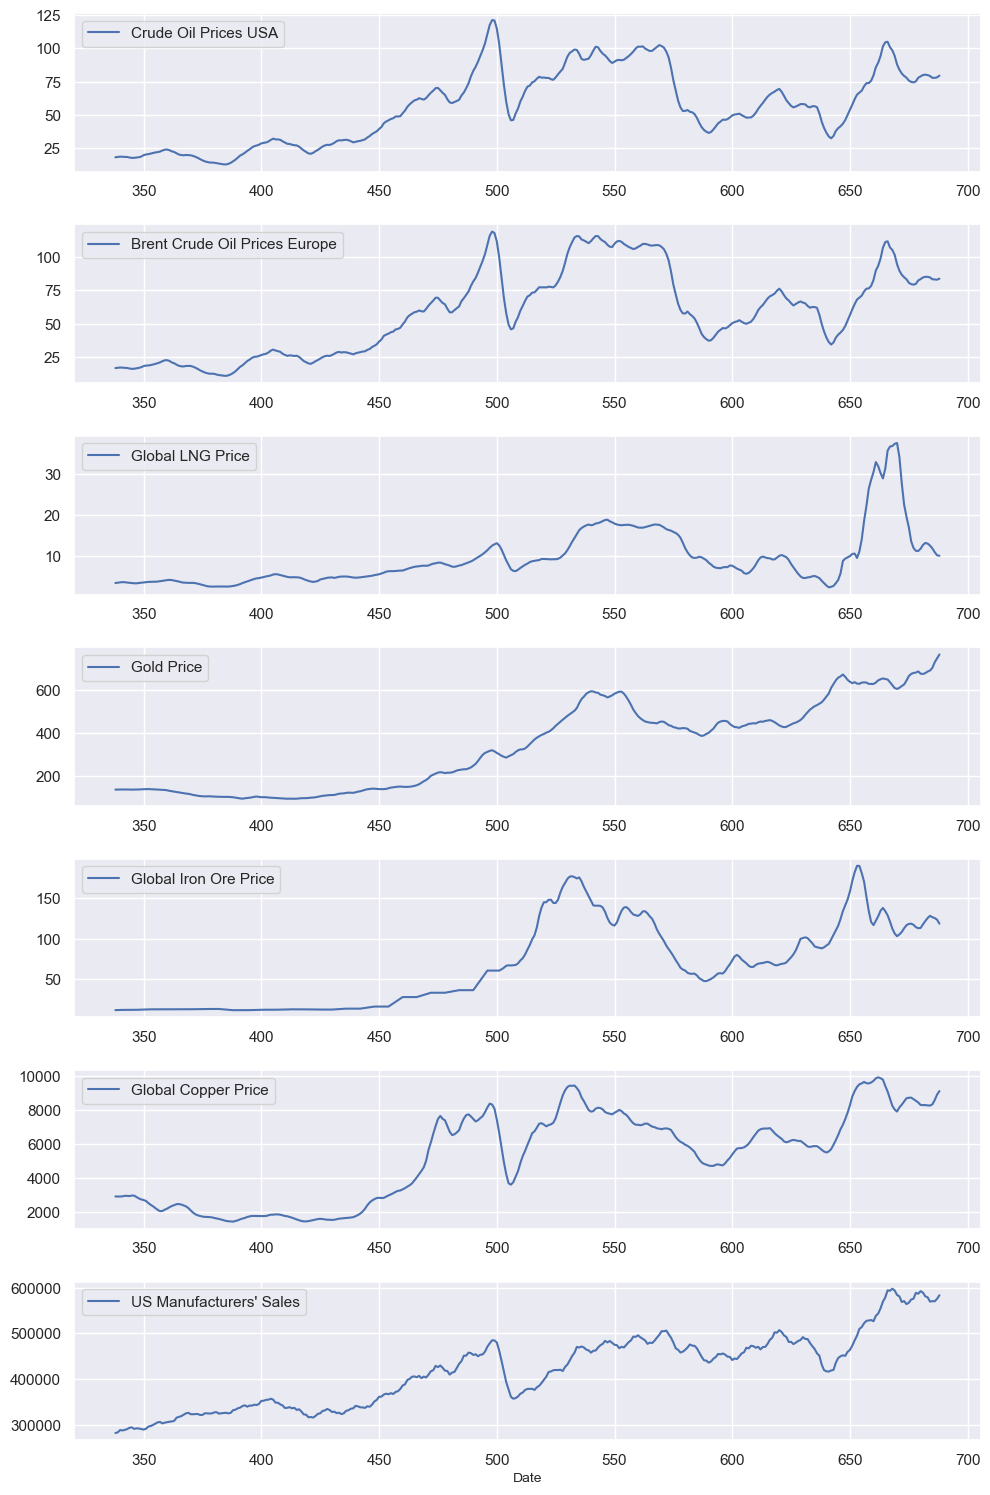

In [691]:
# Define data for each subplot
_crude_oil_us = df["Crude Oil Prices USA"]
_crude_oil_eur = df["Brent Crude Prices Europe"]
_lng = df["Global LNG Price"]
_manuf_sales = df["Manu Sales (USD, millions)"]
_credit_cards_us = df["US Credit Card Rates (%)"]
_flex_price_change = df["Flexible Price CPI % Change"]
_gold_price = df["Gold (USD per 100 kg)"]
_iron_price = df["Iron Ore (USD per metric tonne)"]
_copper_price = df["Copper (USD per metric tonne)"]

# Calculate 6-month moving average
crude_oil_us_ravg = _crude_oil_us.rolling(window=6).mean()
crude_oil_eur_ravg = _crude_oil_eur.rolling(window=6).mean()
lng_ravg = _lng.rolling(window=6).mean()
gold_ravg = _gold_price.rolling(window=6).mean()
iron_ravg = _iron_price.rolling(window=6).mean()
copper_ravg = _copper_price.rolling(window=6).mean()
manuf_sales_ravg = _manuf_sales.rolling(window=6).mean()

# Create multiple subplots
fig, axes = plt.subplots(7, 1, figsize=(10,15))

# Define padding between subplots
fig.tight_layout(pad=1.2)

# Define subplots axes
y_dict = {
    "1": crude_oil_us_ravg,
    "2": crude_oil_eur_ravg,
    "3": lng_ravg,
    "4": gold_ravg,
    "5": iron_ravg,
    "6": copper_ravg,
    "7": manuf_sales_ravg
}

# Create a zipped object of axes position and label
ax_id = [i for i in range(0,len(y_dict.keys()))]
labels = ["Crude Oil Prices USA", "Brent Crude Oil Prices Europe", "Global LNG Price", \
          "Gold Price", "Global Iron Ore Price", "Global Copper Price", "US Manufacturers' Sales"]

# Show subplots for each label
for n, label in zip(ax_id, labels):
    axes[n].plot(y_dict[str(n+1)], label=label)
    axes[n].legend()

plt.xlabel("Date", fontsize=10)
plt.show()

#### 1. US crude oil prices and manufacturers' sales

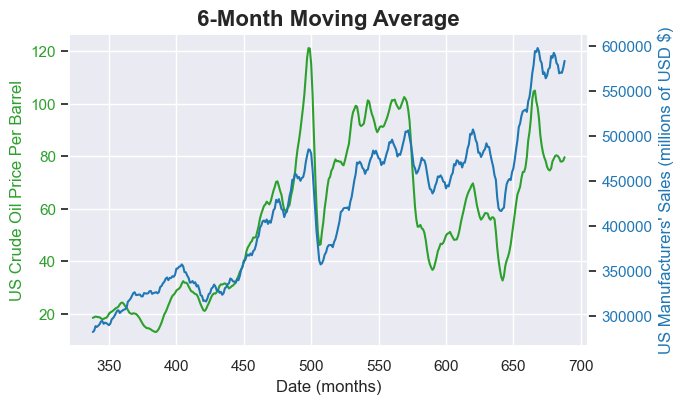

In [693]:
# Define subplot 
fig, ax1 = plt.subplots(figsize=(6,4))
plt.title("6-Month Moving Average", fontsize=16, fontweight="bold")
fig.tight_layout()

# Subplot 1
color = "tab:green"
ax1.set_xlabel("Date (months)")
ax1.set_ylabel("US Crude Oil Price Per Barrel", color=color)
ax1.plot(_crude_oil_us.rolling(window=6).mean(), color=color)
ax1.tick_params(axis="y", labelcolor=color)

# Create duplicate axes of subplot 1
ax2 = ax1.twinx()

# Subplot 2
color = "tab:blue"
ax2.set_ylabel("US Manufacturers' Sales (millions of USD $)", color=color)
ax2.plot(_manuf_sales.rolling(window=6).mean(), color=color)
ax2.tick_params(axis="y", labelcolor=color)
ax2.grid(False)

plt.show()

#### 2. Brent crude oil prices and US manufacturers' sales

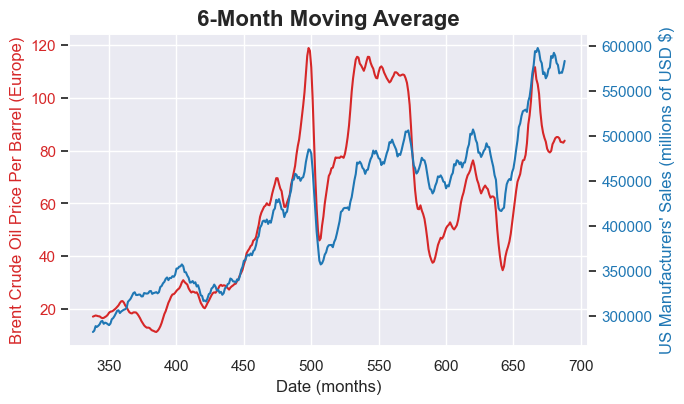

In [695]:
# Define subplot 
fig, ax1 = plt.subplots(figsize=(6,4))
plt.title("6-Month Moving Average", fontsize=16, fontweight="bold")
fig.tight_layout()

# Subplot 1
color = "tab:red"
ax1.set_xlabel("Date (months)")
ax1.set_ylabel("Brent Crude Oil Price Per Barrel (Europe)", color=color)
ax1.plot(_crude_oil_eur.rolling(window=6).mean(), color=color)
ax1.tick_params(axis="y", labelcolor=color)

# Create duplicate axes of subplot 1
ax2 = ax1.twinx()

# Subplot 2
color = "tab:blue"
ax2.set_ylabel("US Manufacturers' Sales (millions of USD $)", color=color)
ax2.plot(_manuf_sales.rolling(window=6).mean(), color=color)
ax2.tick_params(axis="y", labelcolor=color)
ax2.grid(False)

plt.show()

#### 3. Global LNG prices and US manufacturers' sales

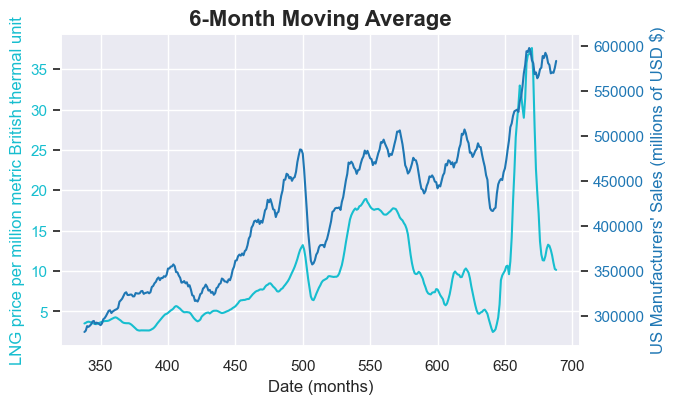

In [697]:
# Define subplot 
fig, ax1 = plt.subplots(figsize=(6,4))
plt.title("6-Month Moving Average", fontsize=16, fontweight="bold")
fig.tight_layout()

# Subplot 1
color = "tab:cyan"
ax1.set_xlabel("Date (months)")
ax1.set_ylabel("LNG price per million metric British thermal unit", color=color)
ax1.plot(_lng.rolling(window=6).mean(), color=color)
ax1.tick_params(axis="y", labelcolor=color)

# Create duplicate axes of subplot 1
ax2 = ax1.twinx()

# Subplot 2
color = "tab:blue"
ax2.set_ylabel("US Manufacturers' Sales (millions of USD $)", color=color)
ax2.plot(_manuf_sales.rolling(window=6).mean(), color=color)
ax2.tick_params(axis="y", labelcolor=color)
ax2.grid(False)

plt.show()

#### 4. Global Gold Prices and US Manufacturers' Sales

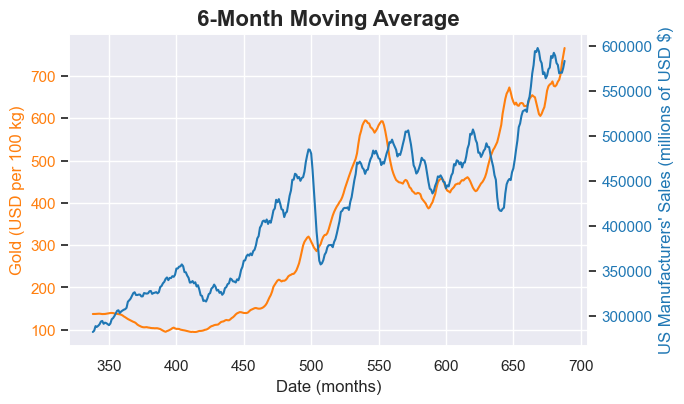

In [699]:
# Define subplot 
fig, ax1 = plt.subplots(figsize=(6,4))
plt.title("6-Month Moving Average", fontsize=16, fontweight="bold")
fig.tight_layout()

# Subplot 1
color = "tab:orange"
ax1.set_xlabel("Date (months)")
ax1.set_ylabel("Gold (USD per 100 kg)", color=color)
ax1.plot(_gold_price.rolling(window=6).mean(), color=color)
ax1.tick_params(axis="y", labelcolor=color)

# Create duplicate axes of subplot 1
ax2 = ax1.twinx()

# Subplot 2
color = "tab:blue"
ax2.set_ylabel("US Manufacturers' Sales (millions of USD $)", color=color)
ax2.plot(_manuf_sales.rolling(window=6).mean(), color=color)
ax2.tick_params(axis="y", labelcolor=color)
ax2.grid(False)

plt.show()

#### 5. Gold Iron Ore Prices and US Manufacturers' Sales

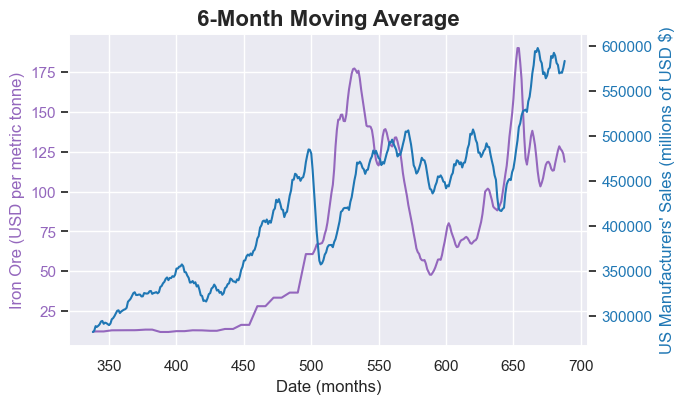

In [701]:
# Define subplot 
fig, ax1 = plt.subplots(figsize=(6,4))
plt.title("6-Month Moving Average", fontsize=16, fontweight="bold")
fig.tight_layout()

# Subplot 1
color = "tab:purple"
ax1.set_xlabel("Date (months)")
ax1.set_ylabel("Iron Ore (USD per metric tonne)", color=color)
ax1.plot(_iron_price.rolling(window=6).mean(), color=color)
ax1.tick_params(axis="y", labelcolor=color)

# Create duplicate axes of subplot 1
ax2 = ax1.twinx()

# Subplot 2
color = "tab:blue"
ax2.set_ylabel("US Manufacturers' Sales (millions of USD $)", color=color)
ax2.plot(_manuf_sales.rolling(window=6).mean(), color=color)
ax2.tick_params(axis="y", labelcolor=color)
ax2.grid(False)

plt.show()

#### 6. Global Copper Prices and US Manufacturers' Sales

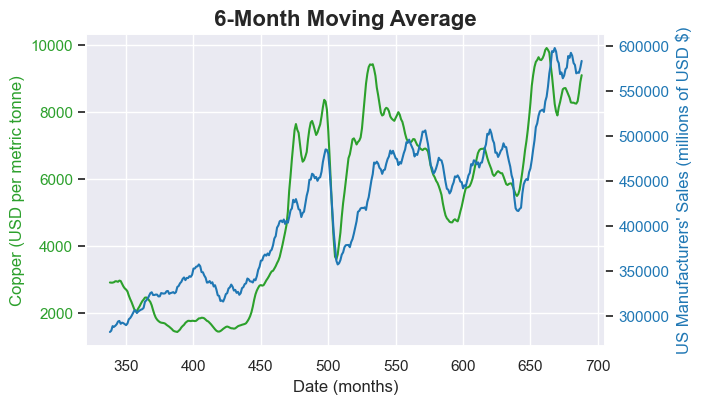

In [703]:
# Define subplot 
fig, ax1 = plt.subplots(figsize=(6,4))
plt.title("6-Month Moving Average", fontsize=16, fontweight="bold")
fig.tight_layout()

# Subplot 1
color = "tab:green"
ax1.set_xlabel("Date (months)")
ax1.set_ylabel("Copper (USD per metric tonne)", color=color)
ax1.plot(_copper_price.rolling(window=6).mean(), color=color)
ax1.tick_params(axis="y", labelcolor=color)

# Create duplicate axes of subplot 1
ax2 = ax1.twinx()

# Subplot 2
color = "tab:blue"
ax2.set_ylabel("US Manufacturers' Sales (millions of USD $)", color=color)
ax2.plot(_manuf_sales.rolling(window=6).mean(), color=color)
ax2.tick_params(axis="y", labelcolor=color)
ax2.grid(False)

plt.show()

### Lag Plots

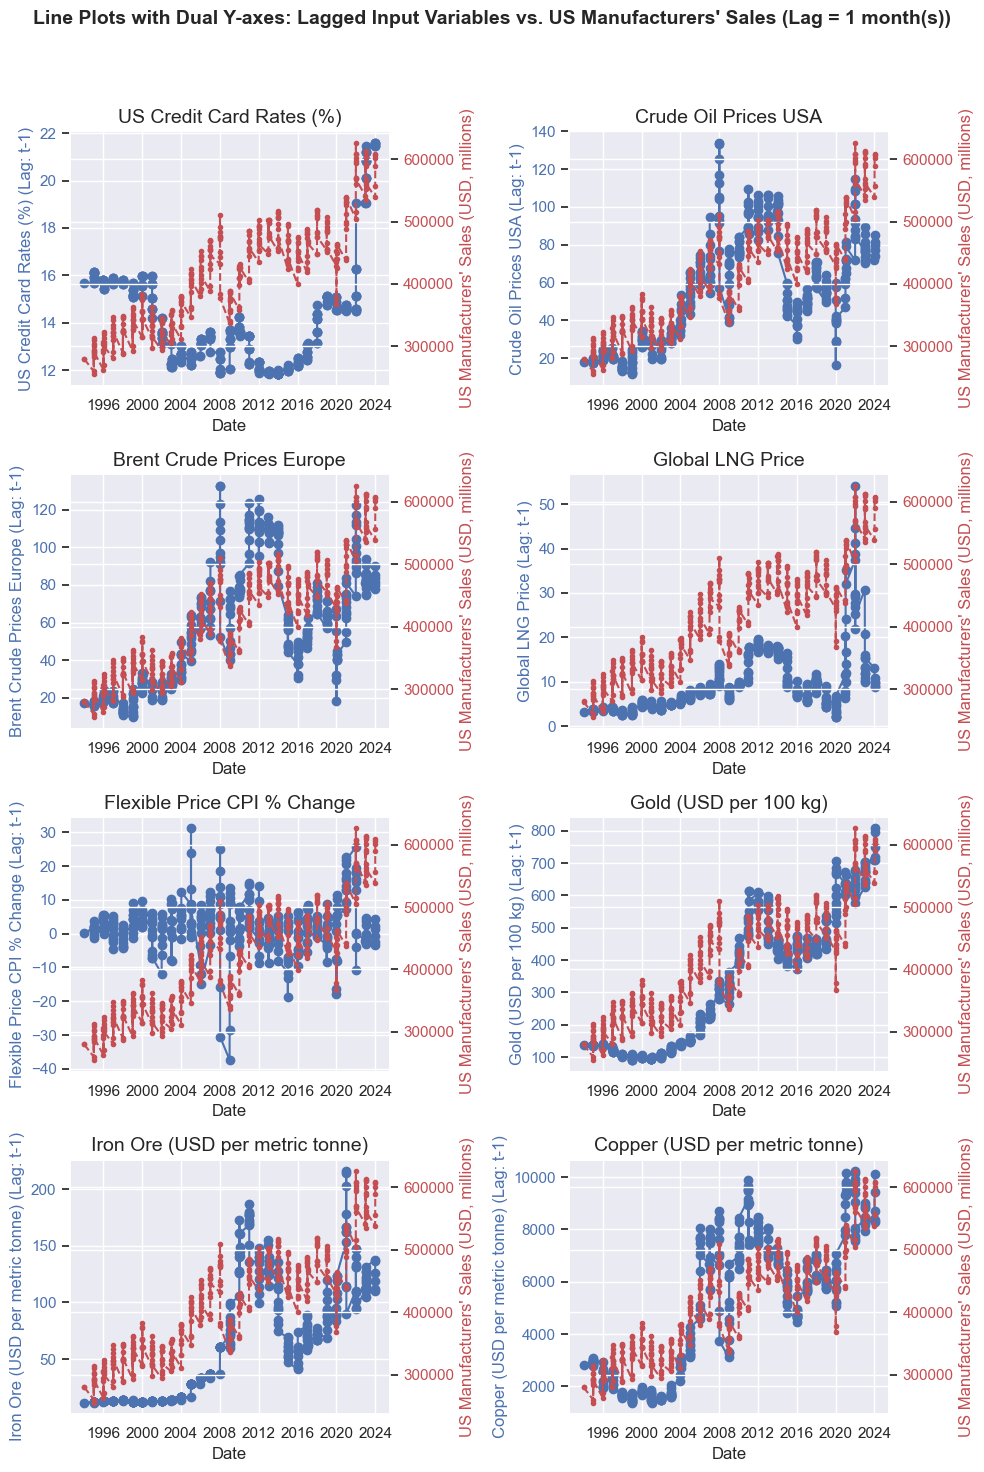

In [705]:
# Create duplicate of dataset
_df = df.copy()

# Define input variables and target
input_variables = _df.columns.to_list()[1:-1]
target_variable = _df.columns.to_list()[-1]

# Define number of lags (1 lag = 1 month)
n_lags = 1

# Create a series of subplots spread over three rows
#fig, axes = plt.subplots(nrows=3, ncols=(len(input_variables) // 2 + len(input_variables) % 2), figsize=(15,10))
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,15))
fig.suptitle(f"Line Plots with Dual Y-axes: Lagged Input Variables vs. US Manufacturers' Sales (Lag = {n_lags} month(s))", \
             fontsize=14, fontweight="bold")

# Flatten axes for easier indexing
axes = axes.flatten()

# Create line plots for each lagged input variable
for i, input_var in enumerate(input_variables):
    # Create lagged version of each input variable
    _df[f"{input_var}_Lag{n_lags}"] = _df[input_var].shift(n_lags)

    # Line plot for lagged input variable on primary y-axis
    ax1 = axes[i]
    ax1.plot(_df["Date"], _df[f"{input_var}_Lag{n_lags}"], label=f"{input_var} (Lag: t-{n_lags})", ls="-", marker="o", color="b")
    ax1.set_xlabel("Date", fontsize=12)
    ax1.set_ylabel(f"{input_var} (Lag: t-{n_lags})", fontsize=12, color="b")
    ax1.tick_params(axis="y", labelcolor="b")

    # Plot target variable on secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(_df["Date"], _df[target_variable], label="US Manufacturers' Sales", ls="--", marker=".", color="r")
    ax2.set_ylabel("US Manufacturers' Sales (USD, millions)", fontsize=12, color="r")
    ax2.tick_params(axis="y", labelcolor="r")

    # Add titles
    ax1.set_title(input_var, fontsize=14)

# Hide unused subplots (if necessary)
for sp in range(len(input_variables), len(axes)):
    axes[sp].axis("off")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Correlation Matrices Using Lagged Input Features

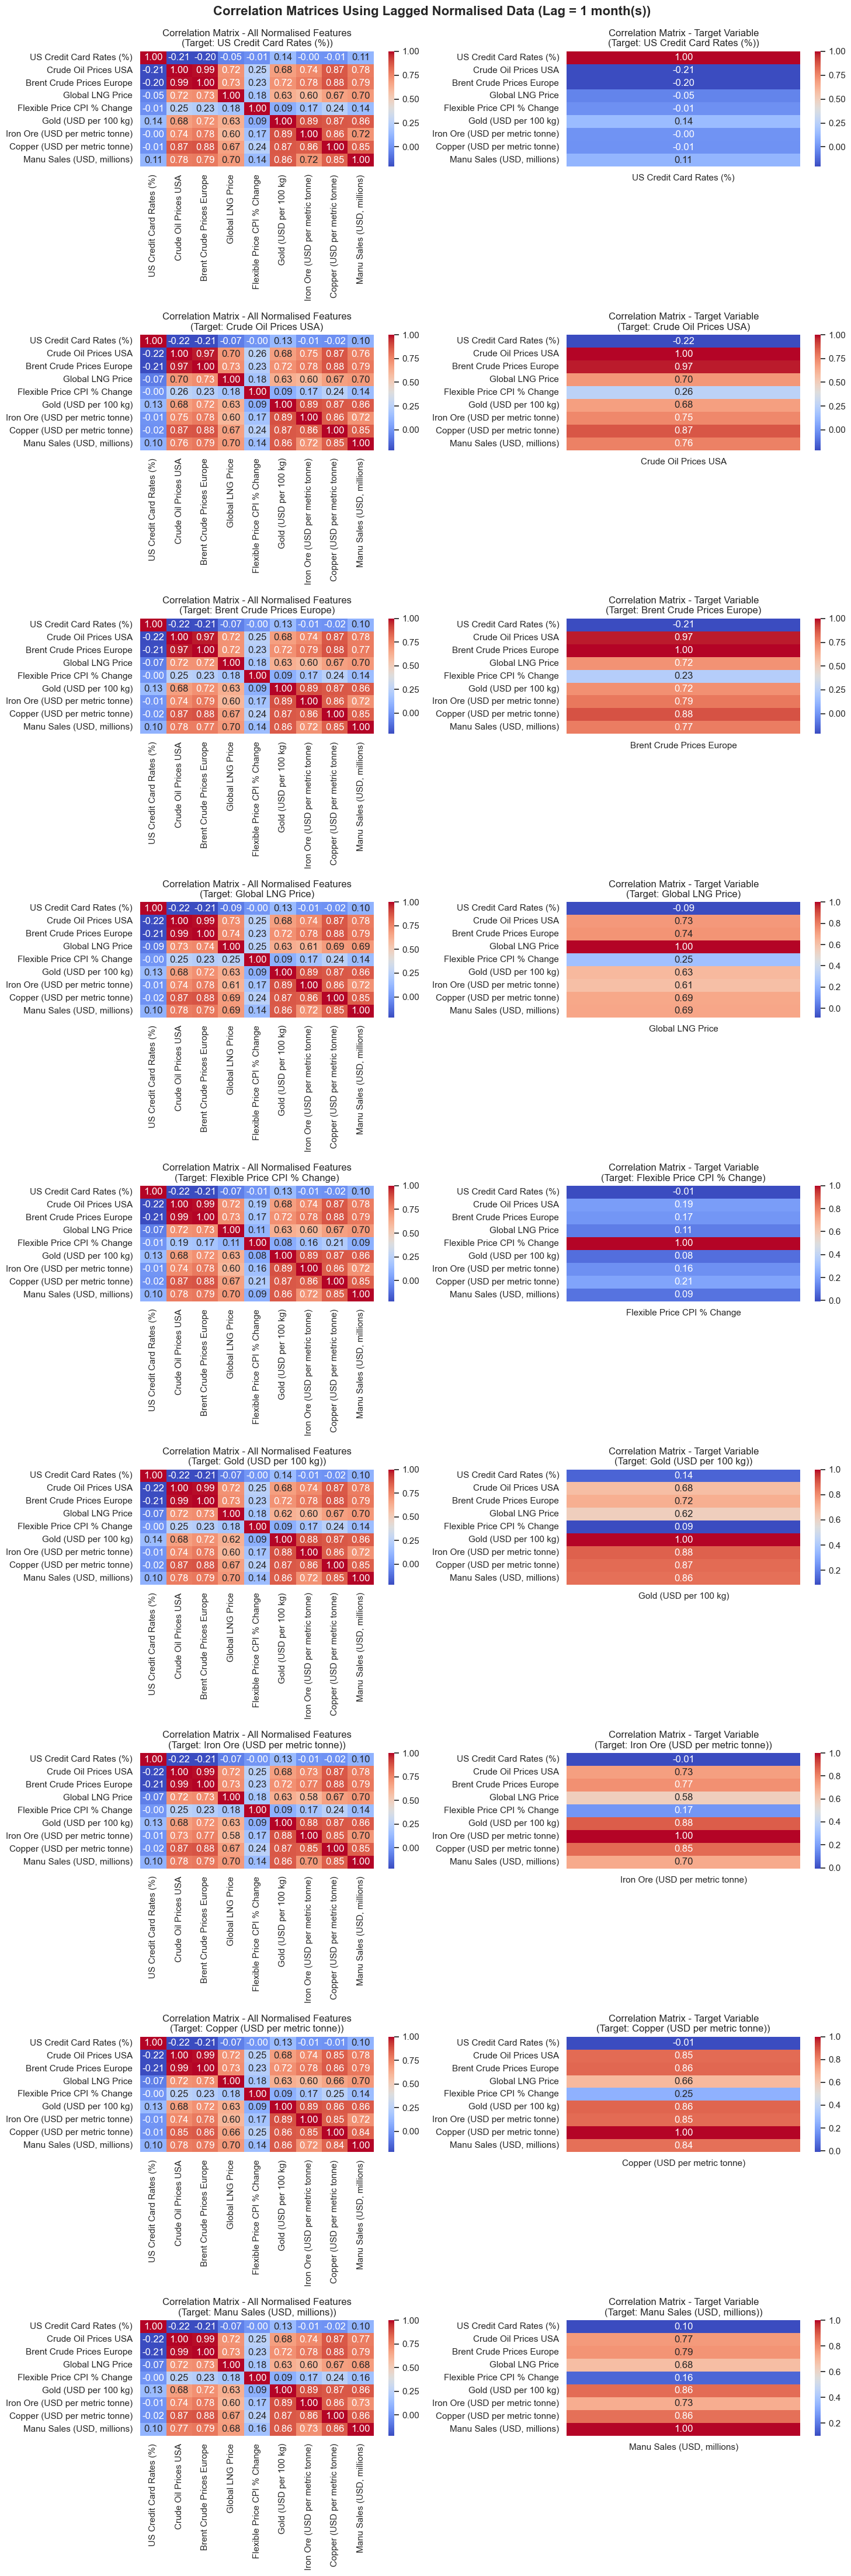

In [707]:
# Create copy of dataset
_df = df.copy()

# Drop "Date" column 
_df.drop("Date", axis=1, inplace=True)

# Normalise all features using MinMaxScaler
scaler = MinMaxScaler()
normalised_df = pd.DataFrame(scaler.fit_transform(_df), columns=_df.columns)

# Initialise lag (number of months) for input features
n_months = 1

# Create lagged input features while looping through all features as target variable
n_features = len(normalised_df.columns)
fig, axes = plt.subplots(nrows=n_features, ncols=2, figsize=(15, 5 * n_features))
fig.suptitle(f"Correlation Matrices Using Lagged Normalised Data (Lag = {n_lags} month(s))\n\n\n", \
             fontsize=16, fontweight="bold")

for i, target_var in enumerate(normalised_df.columns):
    # Set selected feature as target variable and then lag remaining input features by n_months
    lagged_df = normalised_df.copy()
    # Lag all features by n_months
    lagged_df = lagged_df.shift(n_months)
    # Restore selected target variable to unlagged version (i.e., original normalised target data)
    lagged_df[target_var] = normalised_df[target_var]

    # Drop NaN values in lagged dataset
    lagged_df.dropna(inplace=True)

    # Create correlation matrix for all features (i.e., input features and target variable)
    corr_matrix_all = lagged_df.corr(method="pearson")

    # Filter correlation matrix to show correlation scores for selected target variable
    corr_matrix_target = lagged_df.corr(method="pearson")[[target_var]]

    # Plot correlation matrices on two columns
    sns.heatmap(corr_matrix_all, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[i,0])
    axes[i,0].set_title(f"Correlation Matrix - All Normalised Features\n(Target: {target_var})")

    sns.heatmap(corr_matrix_target, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[i,1])
    axes[i,1].set_title(f"Correlation Matrix - Target Variable\n(Target: {target_var})")

# Adjust layout
plt.tight_layout(pad=1.2)

# Display correlation matrices
plt.show()

# 5. Feature Selection

### Correlation Matrix

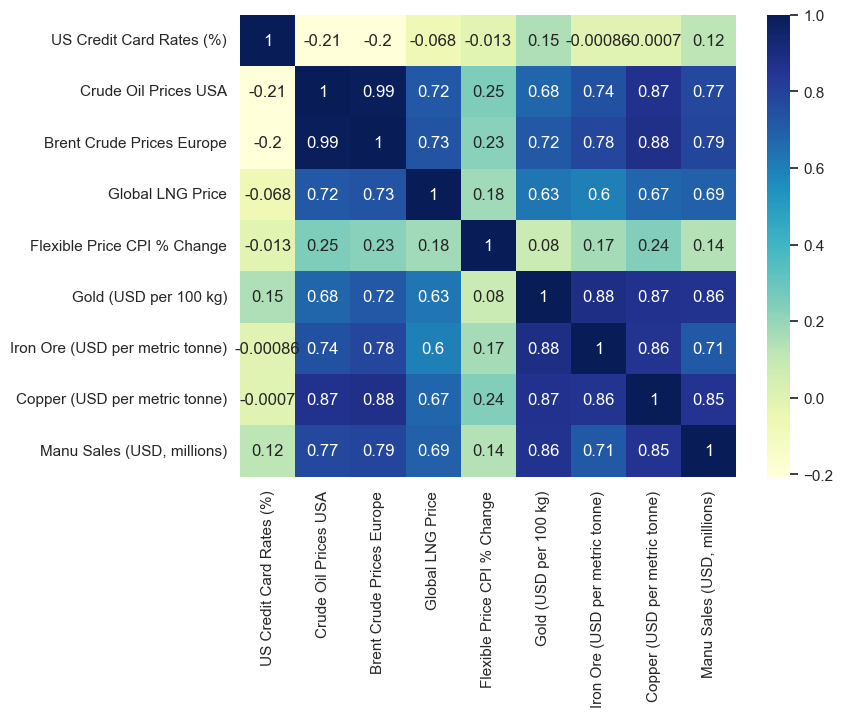

In [710]:
# Set figure size
fig, ax = plt.subplots(figsize=(8,6))

# Generate heatmap showing correlations between input variables and target variable
matrix = sns.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True, ax=ax)

# Show heatmap
plt.show()

### Using PCA for Feature Contribution Analysis

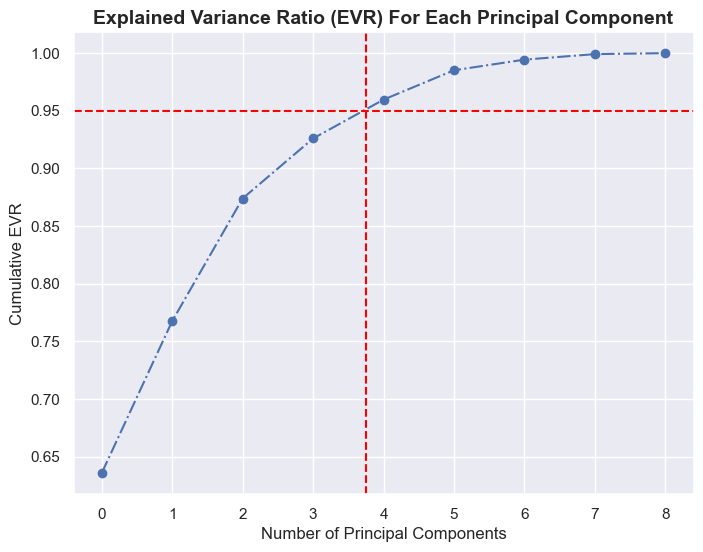


Table of Features Which Contribute to Changes in Target Variable (Principal Components):

                                      PC1       PC2       PC3       PC4  \
US Credit Card Rates (%)        -0.017962  0.845217  0.311398  0.202125   
Crude Oil Prices USA             0.385671 -0.219997 -0.021403  0.091692   
Brent Crude Prices Europe        0.392707 -0.198309 -0.050091  0.055797   
Global LNG Price                 0.332072 -0.071332 -0.025002  0.771675   
Flexible Price CPI % Change      0.102108 -0.259781  0.942235 -0.080077   
Gold (USD per 100 kg)            0.371806  0.281123 -0.088221 -0.277312   
Iron Ore (USD per metric tonne)  0.370318  0.092614 -0.044961 -0.466045   
Copper (USD per metric tonne)    0.399275  0.046138  0.022085 -0.186862   
Manu Sales (USD, millions)       0.375796  0.188605 -0.036601  0.129276   

                                      PC5       PC6       PC7       PC8  \
US Credit Card Rates (%)        -0.254339 -0.286316 -0.023081  0.012956   
Crude Oi

In [712]:
# Create duplicate of dataset
_df = df.copy()

# Remove "Date" column
df_numerical = _df.drop(columns=["Date"])

# Standardise dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numerical)

# Apply PCA to scaled dataset
pca = PCA()
df_pca = pca.fit_transform(scaled_data)

# Determine Explained Variance Ratio (EVR)
explained_var = pca.explained_variance_ratio_

# Plot EVR to gain understanding of how each principal component influences the target variable, US Manufacturers' Sales
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(explained_var), marker="o", ls="-.")
plt.axhline(y=0.95, color="red", ls="--")
plt.axvline(x=3.75, color="red", ls="--")
plt.title("Explained Variance Ratio (EVR) For Each Principal Component", fontsize=14, fontweight="bold")
plt.xlabel("Number of Principal Components", fontsize=12)
plt.ylabel("Cumulative EVR", fontsize=12)
plt.grid(True)
plt.show()

# Determine contribute of each feature to changes in target variable, US Manufacturers' Sales
pca_components = pd.DataFrame(
    pca.components_,
    columns=df_numerical.columns,
    index=[f"PC{i+1}" for i in range(len(pca.components_))]
)

print()
print("Table of Features Which Contribute to Changes in Target Variable (Principal Components):\n")
print(pca_components.T)
print("----" * 20)
print()

# Identify the features which exert the most influence on Principal Component 1 (PC1)
pc1_features = pca_components.loc["PC1"]
most_important_features = pc1_features.abs().sort_values(ascending=False)

print("Features which exert the most influence on the target variable: US Manufacturers' Sales (USD, millions)")
print()
print(most_important_features)

### Using Statistical Tests for Feature Contribution Analysis

In [714]:
# Create duplicate of dataset
_df = df.copy()

# Remove "Date" column and target variable, "Manu Sales (USD, millons)"
features = _df.drop(columns=["Date", "Manu Sales (USD, millions)"])
target_var = _df["Manu Sales (USD, millions)"]

#### Pearson Correlation Coefficient

Pearson Correlation Coefficients:

Gold (USD per 100 kg)              0.862045
Copper (USD per metric tonne)      0.850393
Brent Crude Prices Europe          0.785645
Crude Oil Prices USA               0.774449
Iron Ore (USD per metric tonne)    0.714706
Global LNG Price                   0.693149
Flexible Price CPI % Change        0.135819
US Credit Card Rates (%)           0.116308
dtype: float64
---------------------------------------------



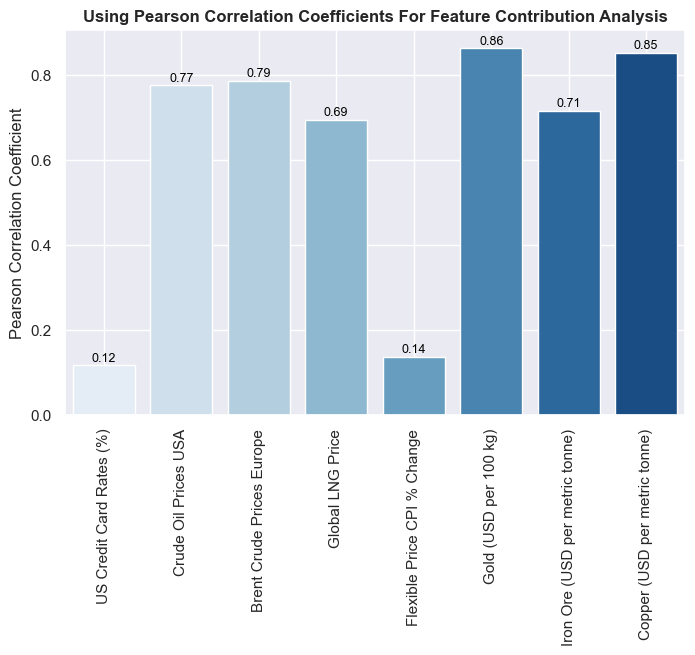

In [716]:
pearson_corr = features.corrwith(target_var)
sorted_pearson_corr = pearson_corr.abs().sort_values(ascending=False)

print("Pearson Correlation Coefficients:")
print()
print(sorted_pearson_corr)
print("---" * 15)
print()

# Visualise correlations
plt.figure(figsize=(8,5))
sns.barplot(x=pearson_corr.index, y=pearson_corr.values, palette="Blues")
plt.title("Using Pearson Correlation Coefficients For Feature Contribution Analysis", fontsize=12, fontweight="bold")
plt.xlabel("")
plt.xticks(rotation=90)
plt.ylabel("Pearson Correlation Coefficient")
plt.grid(True)

# Add labels to each bar showing correlation score
for index, corr_score in enumerate(pearson_corr.values):
    plt.text(index, corr_score+0.01, f"{corr_score:.2f}", ha="center", fontsize=9, color="black")

# Display barplot with correlation scores
plt.show();

#### Spearman Rank Correlation

Spearman Correlation Coefficients:

Gold (USD per 100 kg)              0.842549
Brent Crude Prices Europe          0.825166
Copper (USD per metric tonne)      0.820484
Crude Oil Prices USA               0.802636
Global LNG Price                   0.798695
Iron Ore (USD per metric tonne)    0.782146
US Credit Card Rates (%)           0.233774
Flexible Price CPI % Change        0.065496
dtype: float64
---------------------------------------------



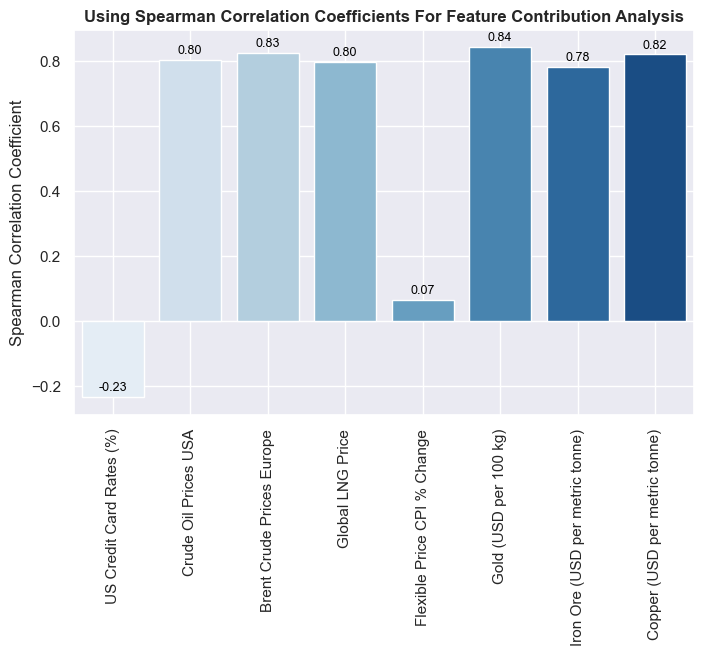

In [718]:
spearman_corr = features.corrwith(target_var, method="spearman")
sorted_spearman_corr = spearman_corr.abs().sort_values(ascending=False)

print("Spearman Correlation Coefficients:")
print()
print(sorted_spearman_corr)
print("---" * 15)
print()

# Visualise correlations
plt.figure(figsize=(8,5))
sns.barplot(x=spearman_corr.index, y=spearman_corr.values, palette="Blues")
plt.title("Using Spearman Correlation Coefficients For Feature Contribution Analysis", fontsize=12, fontweight="bold")
plt.xlabel("")
plt.xticks(rotation=90)
plt.ylabel("Spearman Correlation Coefficient")
plt.grid(True)

# Add labels to each bar showing correlation score
for index, corr_score in enumerate(spearman_corr.values):
    plt.text(index, corr_score+0.02, f"{corr_score:.2f}", ha="center", fontsize=9, color="black")

# Display barplot with correlation scores
plt.show();

#### Mutual Information


                           Feature  Mutual Information
5            Gold (USD per 100 kg)            0.932964
7    Copper (USD per metric tonne)            0.844569
6  Iron Ore (USD per metric tonne)            0.841688
2        Brent Crude Prices Europe            0.808554
1             Crude Oil Prices USA            0.791678
3                 Global LNG Price            0.637736
0         US Credit Card Rates (%)            0.556198
4      Flexible Price CPI % Change            0.159169
------------------------------------------------------------



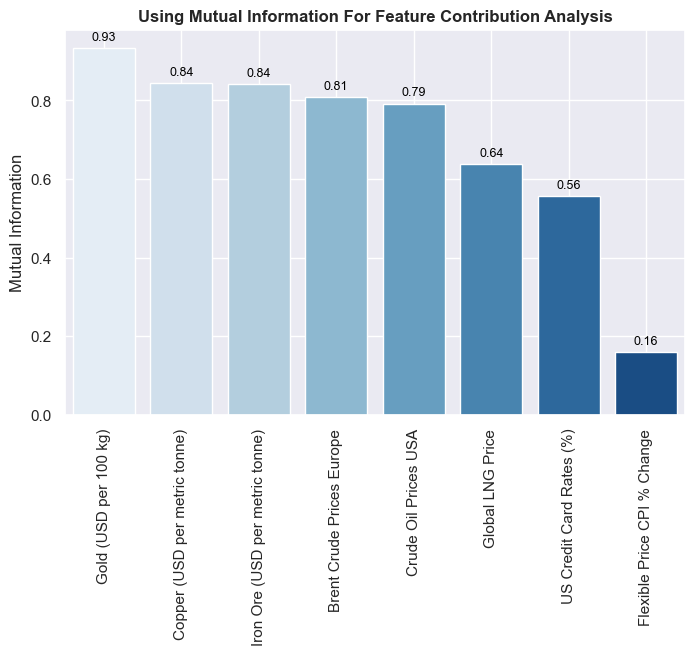

In [720]:
mutual_info = mutual_info_regression(features, target_var)

# Set up dataframe using extracted mutual information
mutual_info_df = pd.DataFrame({
    "Feature": features.columns,
    "Mutual Information": mutual_info
})

# Sort values in descending order
mutual_info_df.sort_values(by="Mutual Information", ascending=False, inplace=True)

print()
print(mutual_info_df)
print("---" * 20)
print()

# Visualise mutual information
plt.figure(figsize=(8,5))
sns.barplot(data=mutual_info_df, x="Feature", y="Mutual Information", palette="Blues")
plt.title("Using Mutual Information For Feature Contribution Analysis", fontsize=12, fontweight="bold")
plt.xlabel("")
plt.xticks(rotation=90)
plt.ylabel("Mutual Information")
plt.grid(True)

# Add labels to each bar showing correlation score
for index, value in enumerate(mutual_info_df["Mutual Information"]):
    plt.text(index, value+0.02, f"{value:.2f}", ha="center", fontsize=9, color="black")

# Display barplot with correlation scores
plt.show();

# 6. Stationarity Tests

US Credit Card Rates (%)
------------------------
ADF Statistic: -1.026
p-value: 0.744
Critical Values:
	1%: -3.449226932880019
	5%: -2.869857365438656
	10%: -2.571201085130664

ADF Test Result: Non-stationary time series

KPSS Statistic: 0.557
p-value: 0.029
Lags used: 11
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

KPSS Test Result: Non-stationary time series
--------------------------------------------------



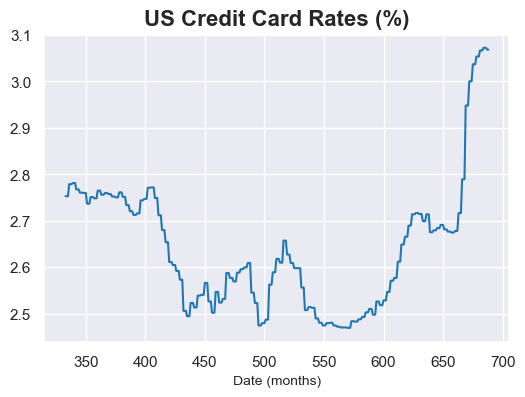


Flexible Price CPI % Change
---------------------------
ADF Statistic: -4.025
p-value: 0.001
Critical Values:
	1%: -3.4497880749874628
	5%: -2.870103829170425
	10%: -2.571332495975496

ADF Test Result: Stationary time series

KPSS Statistic: 0.078
p-value: 0.100
Lags used: 9
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

KPSS Test Result: Stationary time series
--------------------------------------------------



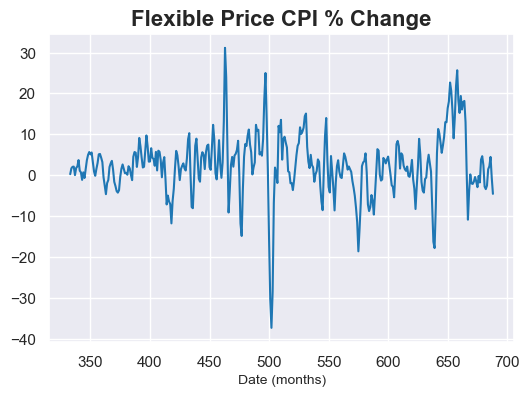


US Crude Oil Price Per Barrel
-----------------------------
ADF Statistic: -2.073
p-value: 0.256
Critical Values:
	1%: -3.4490114443793214
	5%: -2.8697627072503757
	10%: -2.5711506161673716

ADF Test Result: Non-stationary time series

KPSS Statistic: 1.842
p-value: 0.010
Lags used: 11
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

KPSS Test Result: Non-stationary time series
--------------------------------------------------



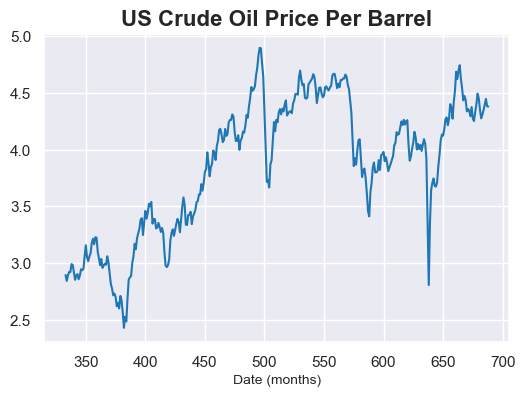


Brent Crude Oil Price Per Barrel (Europe)
-----------------------------------------
ADF Statistic: -1.924
p-value: 0.321
Critical Values:
	1%: -3.4490114443793214
	5%: -2.8697627072503757
	10%: -2.5711506161673716

ADF Test Result: Non-stationary time series

KPSS Statistic: 1.950
p-value: 0.010
Lags used: 11
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

KPSS Test Result: Non-stationary time series
--------------------------------------------------



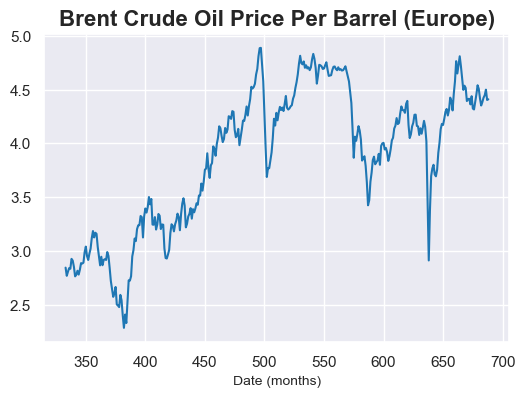


Global LNG Price Per Million Metric BTU
---------------------------------------
ADF Statistic: -2.021
p-value: 0.278
Critical Values:
	1%: -3.449846029628477
	5%: -2.870129281376164
	10%: -2.5713460670144603

ADF Test Result: Non-stationary time series

KPSS Statistic: 1.550
p-value: 0.010
Lags used: 11
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

KPSS Test Result: Non-stationary time series
--------------------------------------------------



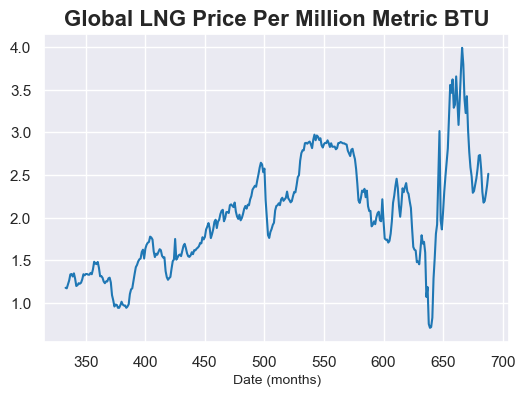


Global Gold Prices Per 100 Kg
-----------------------------
ADF Statistic: 0.264
p-value: 0.976
Critical Values:
	1%: -3.448905534655263
	5%: -2.8697161816205705
	10%: -2.5711258103550882

ADF Test Result: Non-stationary time series

KPSS Statistic: 2.772
p-value: 0.010
Lags used: 11
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

KPSS Test Result: Non-stationary time series
--------------------------------------------------



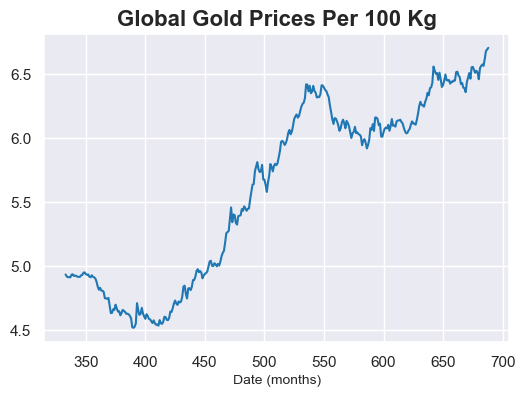


Global Iron Ore Prices Per Metric Tonne
---------------------------------------
ADF Statistic: -1.060
p-value: 0.731
Critical Values:
	1%: -3.44911857009962
	5%: -2.8698097654570507
	10%: -2.5711757061225153

ADF Test Result: Non-stationary time series

KPSS Statistic: 2.495
p-value: 0.010
Lags used: 11
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

KPSS Test Result: Non-stationary time series
--------------------------------------------------



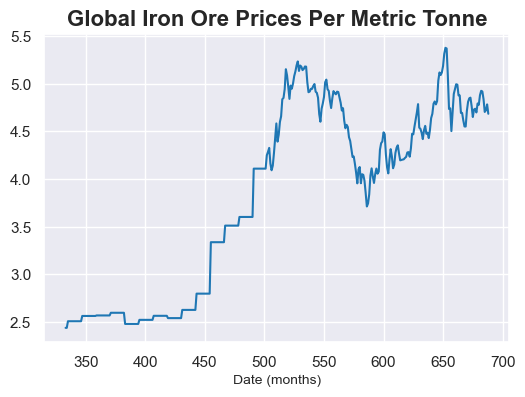


Global Copper Prices Per Metric Tonne
-------------------------------------
ADF Statistic: -1.135
p-value: 0.701
Critical Values:
	1%: -3.4489583388155194
	5%: -2.869739378430086
	10%: -2.5711381780459

ADF Test Result: Non-stationary time series

KPSS Statistic: 2.200
p-value: 0.010
Lags used: 11
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

KPSS Test Result: Non-stationary time series
--------------------------------------------------



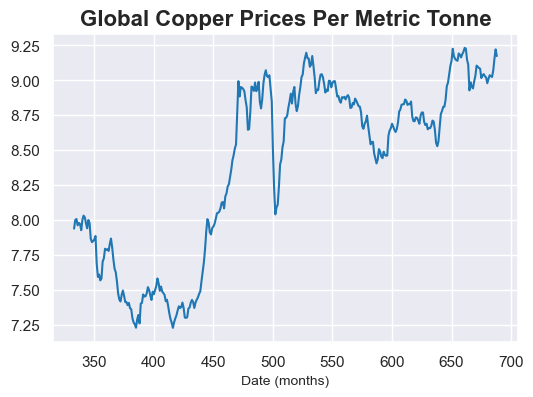


US Manufacturers' Sales
-----------------------
ADF Statistic: -1.112
p-value: 0.710
Critical Values:
	1%: -3.449846029628477
	5%: -2.870129281376164
	10%: -2.5713460670144603

ADF Test Result: Non-stationary time series

KPSS Statistic: 2.692
p-value: 0.010
Lags used: 11
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

KPSS Test Result: Non-stationary time series
--------------------------------------------------



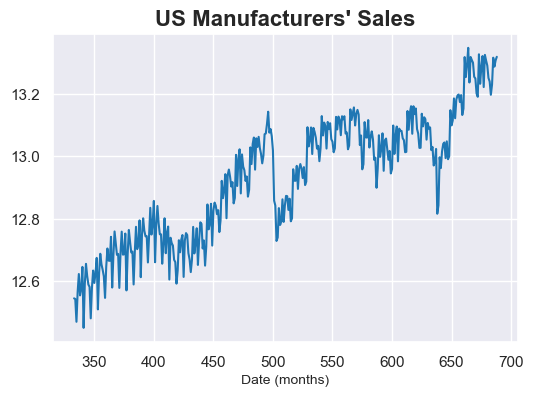

In [722]:
# Determine if time series data is stationary or non-stationary
test_stationarity(_credit_cards_us, "US Credit Card Rates (%)", True)
test_stationarity(_flex_price_change, "Flexible Price CPI % Change", False)
test_stationarity(_crude_oil_us, "US Crude Oil Price Per Barrel", True)
test_stationarity(_crude_oil_eur, "Brent Crude Oil Price Per Barrel (Europe)", True)
test_stationarity(_lng, "Global LNG Price Per Million Metric BTU", True)
test_stationarity(_gold_price, "Global Gold Prices Per 100 Kg", True)
test_stationarity(_iron_price, "Global Iron Ore Prices Per Metric Tonne", True)
test_stationarity(_copper_price, "Global Copper Prices Per Metric Tonne", True)

# Determine if time series data for target variable is stationary or non-stationary
test_stationarity(_manuf_sales, "US Manufacturers' Sales", True)

### Detrending by differences

US Credit Card Rates (%)
------------------------
ADF Statistic: -4.655
p-value: 0.000
Critical Values:
	1%: -3.449226932880019
	5%: -2.869857365438656
	10%: -2.571201085130664

ADF Test Result: Stationary time series

KPSS Statistic: 0.610
p-value: 0.022
Lags used: 10
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

KPSS Test Result: Non-stationary time series
--------------------------------------------------



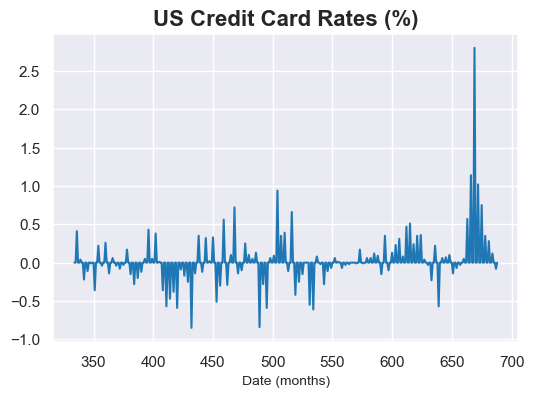


Flexible Price CPI % Change
---------------------------
ADF Statistic: -6.583
p-value: 0.000
Critical Values:
	1%: -3.4499043309021955
	5%: -2.870154885338925
	10%: -2.5713597190254385

ADF Test Result: Stationary time series

KPSS Statistic: 0.069
p-value: 0.100
Lags used: 33
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

KPSS Test Result: Stationary time series
--------------------------------------------------



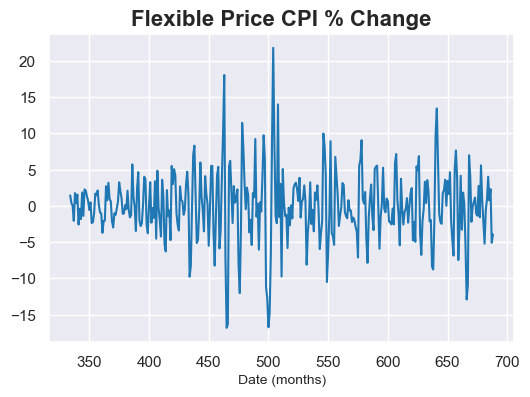


US Crude Oil Price Per Barrel
-----------------------------
ADF Statistic: -13.247
p-value: 0.000
Critical Values:
	1%: -3.4489583388155194
	5%: -2.869739378430086
	10%: -2.5711381780459

ADF Test Result: Stationary time series

KPSS Statistic: 0.035
p-value: 0.100
Lags used: 5
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

KPSS Test Result: Stationary time series
--------------------------------------------------



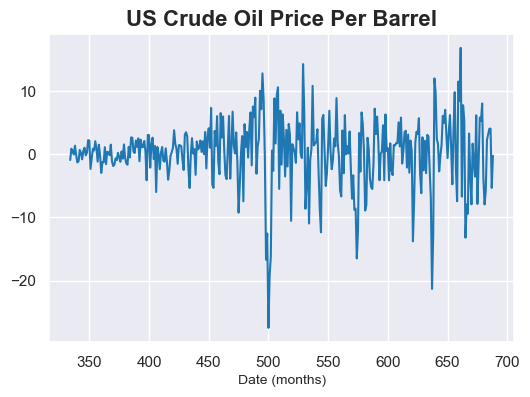


Brent Crude Oil Price Per Barrel (Europe)
-----------------------------------------
ADF Statistic: -13.629
p-value: 0.000
Critical Values:
	1%: -3.4489583388155194
	5%: -2.869739378430086
	10%: -2.5711381780459

ADF Test Result: Stationary time series

KPSS Statistic: 0.042
p-value: 0.100
Lags used: 3
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

KPSS Test Result: Stationary time series
--------------------------------------------------



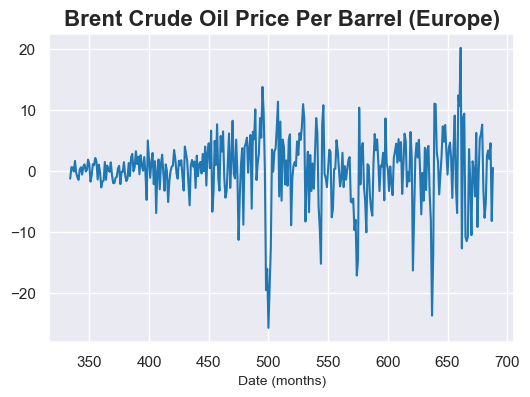


Global LNG Price Per Million Metric BTU
---------------------------------------
ADF Statistic: -5.751
p-value: 0.000
Critical Values:
	1%: -3.4499043309021955
	5%: -2.870154885338925
	10%: -2.5713597190254385

ADF Test Result: Stationary time series

KPSS Statistic: 0.026
p-value: 0.100
Lags used: 14
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

KPSS Test Result: Stationary time series
--------------------------------------------------



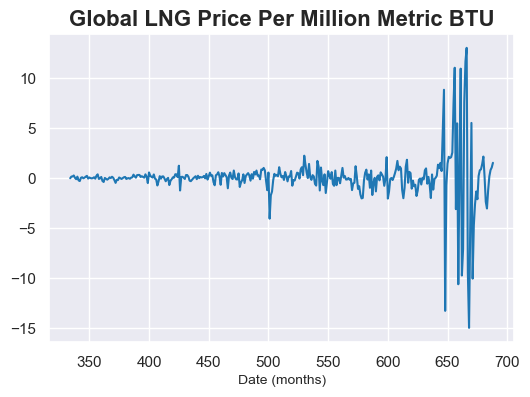


Global Gold Prices Per 100 kg
-----------------------------
ADF Statistic: -18.255
p-value: 0.000
Critical Values:
	1%: -3.4489583388155194
	5%: -2.869739378430086
	10%: -2.5711381780459

ADF Test Result: Stationary time series

KPSS Statistic: 0.284
p-value: 0.100
Lags used: 1
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

KPSS Test Result: Stationary time series
--------------------------------------------------



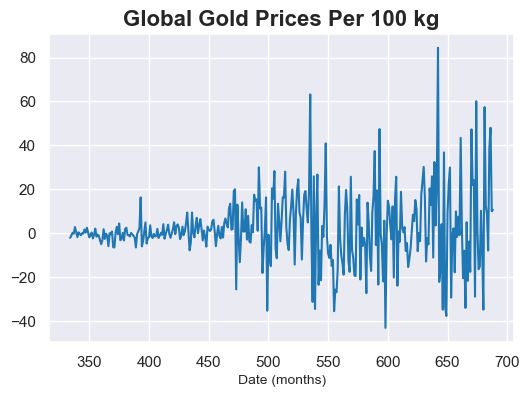


Global Iron Ore Prices Per Metric Tonne
---------------------------------------
ADF Statistic: -11.512
p-value: 0.000
Critical Values:
	1%: -3.44911857009962
	5%: -2.8698097654570507
	10%: -2.5711757061225153

ADF Test Result: Stationary time series

KPSS Statistic: 0.056
p-value: 0.100
Lags used: 0
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

KPSS Test Result: Stationary time series
--------------------------------------------------



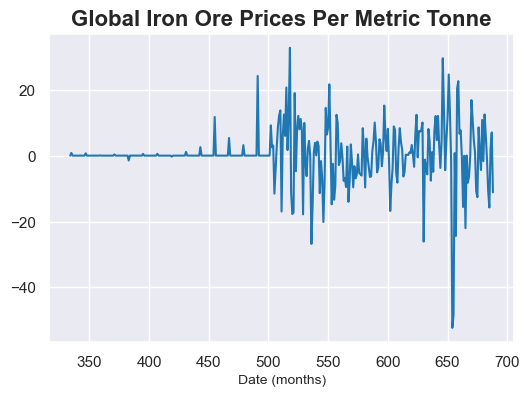


Global Copper Prices Per Metric Tonne
-------------------------------------
ADF Statistic: -5.430
p-value: 0.000
Critical Values:
	1%: -3.449559661646851
	5%: -2.8700035112469626
	10%: -2.5712790073013796

ADF Test Result: Stationary time series

KPSS Statistic: 0.050
p-value: 0.100
Lags used: 5
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

KPSS Test Result: Stationary time series
--------------------------------------------------



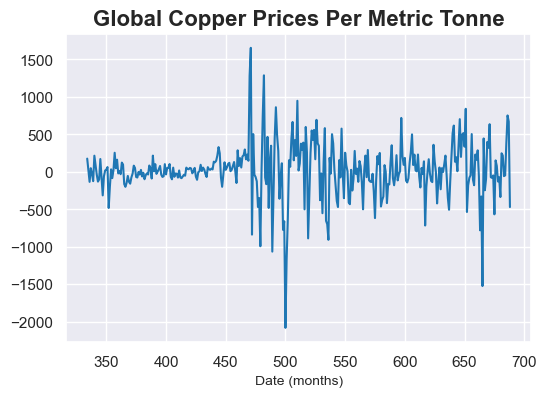


US Manufacturers' Sales
-----------------------
ADF Statistic: -4.725
p-value: 0.000
Critical Values:
	1%: -3.449846029628477
	5%: -2.870129281376164
	10%: -2.5713460670144603

ADF Test Result: Stationary time series

KPSS Statistic: 0.037
p-value: 0.100
Lags used: 9
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739

KPSS Test Result: Stationary time series
--------------------------------------------------



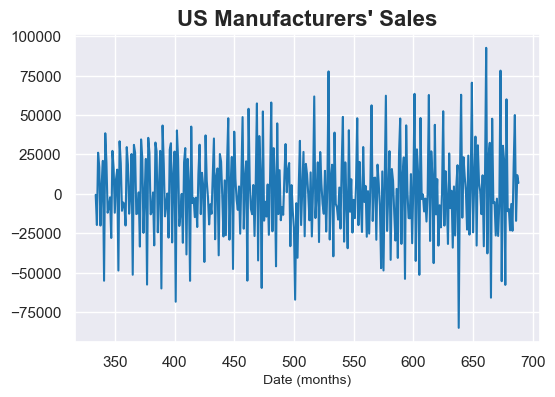

In [724]:
# Using function "test_stationary()" to detrend and test for stationarity for each input variable
_credit_cards_us_dt = detrend_data("US Credit Card Rates (%)", False)
test_stationarity(_credit_cards_us_dt, "US Credit Card Rates (%)", False)

_flex_price_change_dt = detrend_data("Flexible Price CPI % Change", False)
test_stationarity(_flex_price_change_dt, "Flexible Price CPI % Change", False)

_crude_oil_us_dt = detrend_data("Crude Oil Prices USA", False)
test_stationarity(_crude_oil_us_dt, "US Crude Oil Price Per Barrel", False)

_crude_oil_eur_dt = detrend_data("Brent Crude Prices Europe", False)
test_stationarity(_crude_oil_eur_dt, "Brent Crude Oil Price Per Barrel (Europe)", False)

_lng_dt = detrend_data("Global LNG Price", False)
test_stationarity(_lng_dt, "Global LNG Price Per Million Metric BTU", False)

_gold_dt = detrend_data("Gold (USD per 100 kg)", False)
test_stationarity(_gold_dt, "Global Gold Prices Per 100 kg", False)

_iron_dt = detrend_data("Iron Ore (USD per metric tonne)", False)
test_stationarity(_iron_dt, "Global Iron Ore Prices Per Metric Tonne", False)

_copper_dt = detrend_data("Copper (USD per metric tonne)", False)
test_stationarity(_copper_dt, "Global Copper Prices Per Metric Tonne", False)

# Using function "test_stationary()" to detrend and test for stationarity for target variable, US Manufacturers' Sales
_manuf_sales_dt = detrend_data("Manu Sales (USD, millions)", False)
test_stationarity(_manuf_sales_dt, "US Manufacturers' Sales", False)

### Detrended Dataframe

In [726]:
# Set up dictionary to store detrended data series
data_dict = {
    "Date": df["Date"],
    "US Credit Card Rates (%)": _credit_cards_us_dt,
    "Crude Oil Prices USA": _crude_oil_us_dt,
    "Brent Crude Prices Europe": _crude_oil_eur_dt,
    "Global LNG Price": _lng_dt,
    "Flexible Price CPI % Change": _flex_price_change_dt,
    "Gold (USD per 100 kg)": _gold_dt,
    "Iron Ore (USD per metric tonne)": _iron_dt,
    "Copper (USD per metric tonne)": _copper_dt,
    "Manu Sales (USD, millions)": _manuf_sales_dt
}

# Create dataframe with detrended data
df_dt = pd.DataFrame(data_dict)

In [727]:
# Check for missing data in detrended dataframe
find_missing_values(df_dt)

US Credit Card Rates (%)           1
Crude Oil Prices USA               1
Brent Crude Prices Europe          1
Global LNG Price                   1
Flexible Price CPI % Change        1
Gold (USD per 100 kg)              1
Iron Ore (USD per metric tonne)    1
Copper (USD per metric tonne)      1
Manu Sales (USD, millions)         1
dtype: int64

In [728]:
# Drop missing values
df_dt.dropna(axis=0, inplace=True)

In [729]:
# Preview of detrended dataframe
df_dt.head()

Date  US Credit Card Rates (%)  Crude Oil Prices USA  \
334  1994-01-12                      0.00                 -0.91   
335  1995-01-01                      0.00                  0.88   
336  1995-01-02                      0.41                  0.53   
337  1995-01-03                      0.00                 -0.03   
338  1995-01-04                      0.00                  1.36   

     Brent Crude Prices Europe  Global LNG Price  Flexible Price CPI % Change  \
334                      -1.26             -0.02                     1.434452   
335                       0.62              0.15                     0.374042   
336                       0.56              0.16                     0.040837   
337                      -0.10              0.26                    -2.075447   
338                       1.64              0.02                     1.750469   

     Gold (USD per 100 kg)  Iron Ore (USD per metric tonne)  \
334                   -2.1                             0.00   
335                   -0.9                             0.82   
336                    0.2                             0.00   
337                   -0.2                             0.00   
338                    2.8                             0.00   

     Copper (USD per metric tonne)  Manu Sales (USD, millions)  
334                     177.154585                      -567.0  
335                      22.561899                    -19713.0  
336                    -132.811737                     26115.0  
337                      49.223820                     16911.0  
338                     -24.785155                    -20072.0

### Detrended correlation matrix

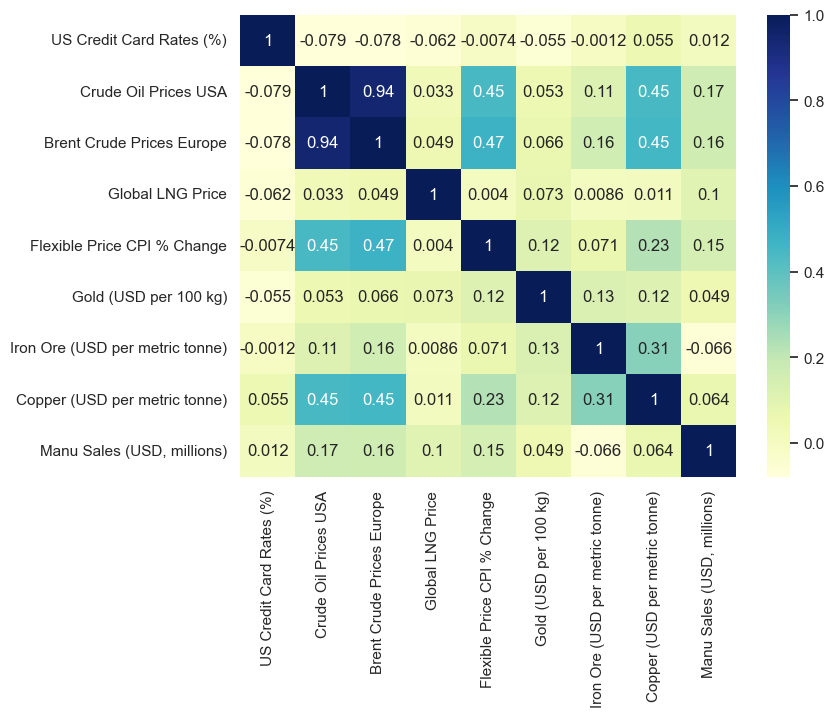

In [731]:
# Set figure size
fig, ax = plt.subplots(figsize=(8,6))

# Generate heatmap showing correlations between input variables and target variable
matrix = sns.heatmap(df_dt.corr(numeric_only=True), cmap="YlGnBu", annot=True, ax=ax)

# Show heatmap
plt.show()

# 6. Model Development

### Pre-Modelling Normalisation of Dataset

In [734]:
if "diff" in df.columns.to_list():
    df.drop("diff", axis=1, inplace=True)

# Set up training (X) and test (y, "Manu Sales") sets
X = df.drop(["Date", "US Credit Card Rates (%)", "Global LNG Price", "Flexible Price CPI % Change", "Manu Sales (USD, millions)"], axis=1)
y = df["Manu Sales (USD, millions)"]

# Initialise MinMaxScaler for both input features and target variable
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit input features to scaler object and transform features (X)
scaled_features = feature_scaler.fit_transform(X)

# Scale target variable
scaled_target = target_scaler.fit_transform(y.values.reshape(-1,1))

# Convert scaled input features into data frame
X = pd.DataFrame(scaled_features, columns=X.columns)

# Convert scaled target into data series
y = pd.Series(scaled_target.flatten(), name="Manu Sales (USD, millions)")

# Display scaled input variables
print("Scaled Input Variables (Range: 0 to 1):")
print()
X.head()

Scaled Input Variables (Range: 0 to 1):



Crude Oil Prices USA  Brent Crude Prices Europe  Gold (USD per 100 kg)  \
0              0.054844                   0.059967               0.065289   
1              0.047417                   0.049715               0.062397   
2              0.054599                   0.054760               0.061157   
3              0.058924                   0.059317               0.061433   
4              0.058680                   0.058503               0.061157   

   Iron Ore (USD per metric tonne)  Copper (USD per metric tonne)  
0                         0.000000                       0.161085  
1                         0.000000                       0.181095  
2                         0.004012                       0.183643  
3                         0.004012                       0.168642  
4                         0.004012                       0.174202

In [735]:
# Show scaled target, US Manufacturers' Sales
y

0      0.068209
1      0.066680
2      0.013517
3      0.083946
4      0.129552
         ...   
351    0.812675
352    0.947473
353    0.901443
354    0.933492
355    0.952220
Name: Manu Sales (USD, millions), Length: 356, dtype: float64

### Create models for sequential testing

In [737]:
# Define hyperparameters
gbr_params = {"n_estimators": 350, "learning_rate": 0.1, "max_depth": 5, "min_samples_split": 4, "loss": "huber"}

svr_params = {"C": 1.0, "gamma": "auto", "kernel": "rbf"}

rfr_params = {"n_estimators": 50, "max_features": 10, "max_depth": 3, "max_leaf_nodes": 6}

xgb_params = {"learning_rate": 0.1, "max_depth": 5, "subsample": 0.8}

# Define excluded models
excluded_models = []

# Call function to generate list of models
models = model_selection(excluded_models, gbr_params, svr_params, rfr_params, xgb_params)

# Display models (name, algorithm)
models

[('SVR', SVR(gamma='auto')),
 ('RFR',
  RandomForestRegressor(max_depth=3, max_features=10, max_leaf_nodes=6,
                        n_estimators=50)),
 ('GBR',
  GradientBoostingRegressor(loss='huber', max_depth=5, min_samples_split=4,
                            n_estimators=350)),
 ('XGB',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
   

### Use models to sequentially train and test normalised dataset

Test split: 10.0%
Model:       Mean Error:    Standard Deviation:
SVR:        -0.06740       0.00482
RFR:        -0.07723       0.00662
GBR:        -0.06436       0.00692
XGB:        -0.06186       0.00782

Best performing model: XGB
Worst performing model: RFR

4 best performing models
---------------------------
	1. -> XGB
	2. -> GBR
	3. -> SVR
	4. -> RFR



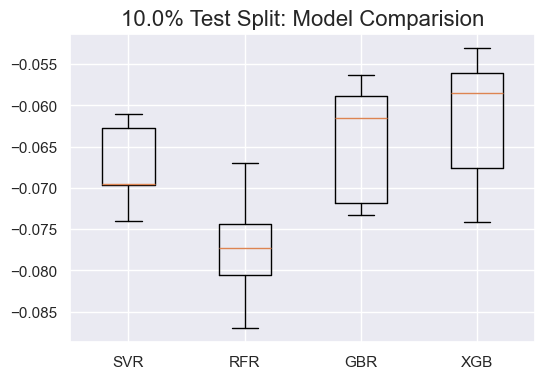

----------------------------------------
Test split: 15.0%
Model:       Mean Error:    Standard Deviation:
SVR:        -0.06849       0.00339
RFR:        -0.07530       0.00511
GBR:        -0.06020       0.00381
XGB:        -0.05994       0.00436

Best performing model: XGB
Worst performing model: RFR

4 best performing models
---------------------------
	1. -> XGB
	2. -> GBR
	3. -> SVR
	4. -> RFR



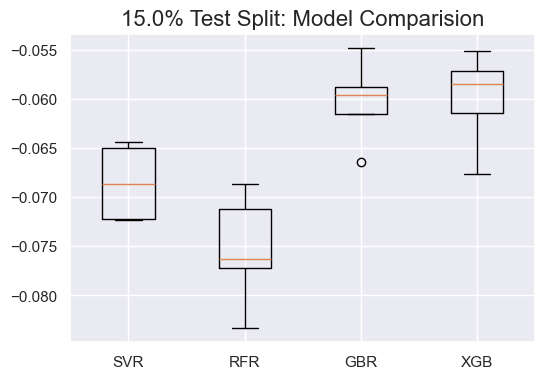

----------------------------------------
Test split: 20.0%
Model:       Mean Error:    Standard Deviation:
SVR:        -0.06937       0.00343
RFR:        -0.07395       0.00505
GBR:        -0.06143       0.00293
XGB:        -0.05950       0.00342

Best performing model: XGB
Worst performing model: RFR

4 best performing models
---------------------------
	1. -> XGB
	2. -> GBR
	3. -> SVR
	4. -> RFR



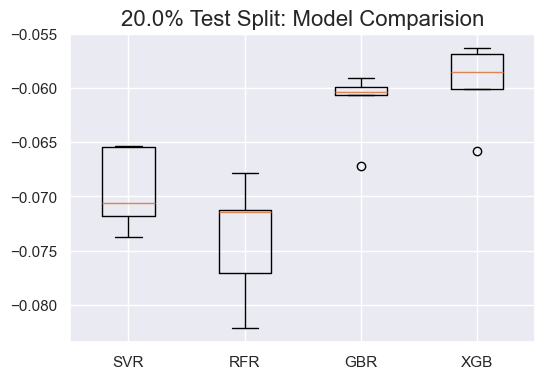

----------------------------------------
Test split: 25.0%
Model:       Mean Error:    Standard Deviation:
SVR:        -0.06987       0.00538
RFR:        -0.07237       0.00447
GBR:        -0.06175       0.00412
XGB:        -0.06223       0.00432

Best performing model: GBR
Worst performing model: RFR

4 best performing models
---------------------------
	1. -> GBR
	2. -> XGB
	3. -> SVR
	4. -> RFR



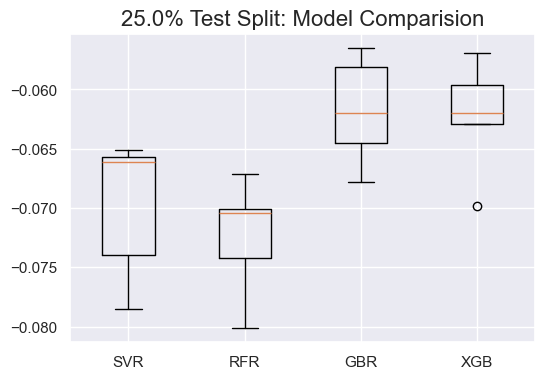

----------------------------------------
Test split: 30.0%
Model:       Mean Error:    Standard Deviation:
SVR:        -0.06966       0.00539
RFR:        -0.07221       0.00754
GBR:        -0.06360       0.00696
XGB:        -0.06354       0.00712

Best performing model: XGB
Worst performing model: RFR

4 best performing models
---------------------------
	1. -> XGB
	2. -> GBR
	3. -> SVR
	4. -> RFR



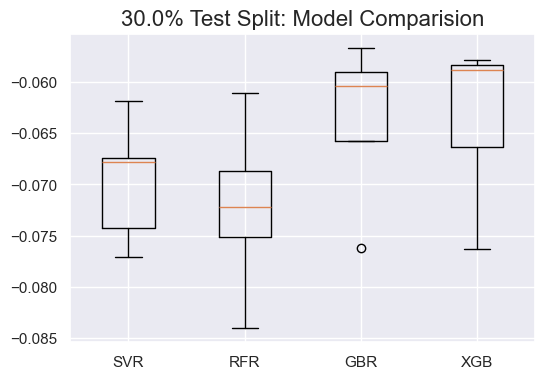

----------------------------------------



In [739]:
# Create nested dictionary to store all cross validation test results for each test fraction
cv_results_all = dict()

# Determine model accuracy for sequence of test splits: 10%, 15%, and 25%
for test_split_fraction in [0.10, 0.15, 0.20, 0.25, 0.30]:
    # Split dataset into training and test sets 
    X_train, X_test, y_train, y_test, test_split = split_dataset(X, y, test_split_fraction)

    # Create lists to store model names and results
    names, results, split = [], [], []

    print(f"Test split: {test_split*100}%")
    print("Model:       Mean Error:    Standard Deviation:")

    # Initialise nested dictionary for each test_split_fraction
    if test_split_fraction not in cv_results_all:
        cv_results_all[test_split_fraction] = dict()

    for name, model in models:
        # Cross validation 
        cv_results = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
        results.append(cv_results)
        names.append(name)
        split.append(test_split_fraction)
        # Display results
        print(f"{name}:        {cv_results.mean():.5f}       {cv_results.std():.5f}")
        # Add cross validation results to dictionary
        cv_results_all[test_split_fraction][name] = [cv_results.mean(), cv_results.std()]
    print("\r")
    # Call function to find best and worst performing models
    find_best_worst_model(names, results)
    # Generate plot
    plot_cv_scores(results, test_split_fraction)
    print("--" * 20)
print("\r")

In [740]:
cv_results_all

{0.1: {'SVR': [-0.06740289935551172, 0.004817813036888962],
  'RFR': [-0.07722580460515874, 0.006621955901631639],
  'GBR': [-0.06435896578901804, 0.006918095032448389],
  'XGB': [-0.061860349388728295, 0.007821835965552859]},
 0.15: {'SVR': [-0.06848788837012827, 0.003391091608946624],
  'RFR': [-0.07529663327396878, 0.0051100563917507134],
  'GBR': [-0.06019503569864071, 0.0038142934695708872],
  'XGB': [-0.059936823045387125, 0.004359611518704383]},
 0.2: {'SVR': [-0.0693731800671806, 0.003432247731646847],
  'RFR': [-0.07394508741721313, 0.005047899553152681],
  'GBR': [-0.06143185481652073, 0.0029339395799030292],
  'XGB': [-0.0594967572798165, 0.0034159090187238796]},
 0.25: {'SVR': [-0.06986870264269877, 0.005384485673008006],
  'RFR': [-0.07237233093762276, 0.004465172903822097],
  'GBR': [-0.061751729492534935, 0.004124121099350039],
  'XGB': [-0.06223159170443138, 0.004315583142279884]},
 0.3: {'SVR': [-0.0696577454496086, 0.005391874069644964],
  'RFR': [-0.0722123540663534,

### Optimal Test Set Split

In [742]:
# Initialise variables to store lowest mean cross validation score and model for each test split
lowest_mean_cv_score = float("inf")
best_model = None

# Initialise dictionary to store test split fraction, best model, and lowest score
cv_results_best = dict()

# Iterate through nested dictionary, cv_results_all
for test_split_fraction, models in cv_results_all.items():
    # Iterate through models and corresponding cross validation scores
    for model_name, scores in models.items():
        # Extract mean cross validation score from nested list and convert to absolute value
        mean_score = abs(scores[0])
        if mean_score < lowest_mean_cv_score:
            lowest_mean_cv_score = mean_score
            best_model = model_name

    # Add model name and corresponding lowest mean CV score to dictionary
    cv_results_best[test_split_fraction] = [best_model, lowest_mean_cv_score]

    # Reset variable for each change in test_split_fraction
    lowest_mean_cv_score, best_model = float("inf"), None

cv_results_best

{0.1: ['XGB', 0.061860349388728295],
 0.15: ['XGB', 0.059936823045387125],
 0.2: ['XGB', 0.0594967572798165],
 0.25: ['GBR', 0.061751729492534935],
 0.3: ['XGB', 0.0635429108723327]}

In [743]:
# Sort cv_results_best by lowest mean CV score
sorted_cv_results_best = sorted(list(cv_results_best.items()), key=lambda t: t[1][1], reverse=False)

# Extracted optimal test split and best untuned model from sorted dictionary
BEST_TEST_SPLIT = sorted_cv_results_best[0][0]
best_model = sorted_cv_results_best[0][1][0]

print()
print("---" * 12)
print(f"Best Untuned Model Test Split: {BEST_TEST_SPLIT * 100}%")
print("---" * 12)
print(f"Best Untuned Model: {best_model}")
print("---" * 12)
print()


------------------------------------
Best Untuned Model Test Split: 20.0%
------------------------------------
Best Untuned Model: XGB
------------------------------------



# 7. Hyperparameter tuning using GridSearchCV

In [745]:
# Set up dictionary to store optimised parameters
optimised_hyperparameters = {}

### XGBoost Regressor (XGB)

In [747]:
# Define hyperparameter dictionary
xgb_params = {
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "max_depth": [3, 5, 7],
    "subsample": [0.8, 0.9, 1.0]
}

# Set up GridSearchCV algorithm
grid_search = GridSearchCV(XGBRegressor(), param_grid=xgb_params, refit=True, verbose=1)
grid_search.fit(X_train, y_train)

# Add optimised hyperparameters to dictionary
optimised_hyperparameters["XGB"] = grid_search.best_params_

# Show best hyperparameter after tuning
print(grid_search.best_params_)

# Show how model appears after tuning
print(grid_search.best_estimator_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)


### Support Vector Regressor (SVR)

In [749]:
# Define hyperparameter dictionary
svr_param_grid = {
    "C": [0.1, 1, 10, 100, 150],
    "gamma": [1, 0.1, 0.01, 0.001],
    "kernel": ["rbf"]
}

grid_search = GridSearchCV(SVR(), param_grid=svr_param_grid, refit=True, verbose=1)
grid_search.fit(X_train, y_train)

# Add optimised hyperparameters to dictionary
optimised_hyperparameters["SVR"] = grid_search.best_params_

# Show best parameter after tuning
print(grid_search.best_params_)

# Show how model appears after tuning
print(grid_search.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
SVR(C=10, gamma=1)


### Gradient Boosting Regressor (GBR)

In [751]:
# Define hyperparameter dictionary
gbr_param_grid = {
    "n_estimators": np.arange(50, 151, 50),
    "learning_rate": np.linspace(0.01, 0.1, 50),
    "max_depth": np.arange(2,6)
}

grid_search = GridSearchCV(GradientBoostingRegressor(), param_grid=gbr_param_grid, refit=True, verbose=1)
grid_search.fit(X_train, y_train)

# Add optimised hyperparameters to dictionary
optimised_hyperparameters["GBR"] = grid_search.best_params_

# Show best parameter after tuning
print(grid_search.best_params_)

# Show how model appears after tuning
print(grid_search.best_estimator_)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
{'learning_rate': 0.09816326530612245, 'max_depth': 3, 'n_estimators': 50}
GradientBoostingRegressor(learning_rate=0.09816326530612245, n_estimators=50)


### Random Forest Regressor (RFR)

In [753]:
# Define hyperparameter dictionary
rfr_param_grid = {
    "n_estimators": np.arange(25, 126, 25),
    "max_features": ["sqrt", "log2", None],
    "max_depth": np.arange(3, 16, 3)
}

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(RandomForestRegressor(), param_grid=rfr_param_grid, refit=True, verbose=1)
grid_search.fit(X_train, y_train)

# Add optimised hyperparameters to dictionary
optimised_hyperparameters["RFR"] = grid_search.best_params_

# Show best parameter after tuning
print(grid_search.best_params_)

# Show how model appears after tuning
print(grid_search.best_estimator_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
{'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 125}
RandomForestRegressor(max_depth=12, max_features='sqrt', n_estimators=125)


### Create optimised models for sequential training and testing

Hyperparameter tuning has led to the following optimised models:

In [756]:
# Display optimised hyperparameters
optimised_hyperparameters

{'XGB': {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8},
 'SVR': {'C': 10, 'gamma': 1, 'kernel': 'rbf'},
 'GBR': {'learning_rate': 0.09816326530612245,
  'max_depth': 3,
  'n_estimators': 50},
 'RFR': {'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 125}}

In [757]:
# Extract tuned hyperparameters
xgb_params = optimised_hyperparameters["XGB"]
svr_params = optimised_hyperparameters["SVR"]
gbr_params = optimised_hyperparameters["GBR"]
rfr_params = optimised_hyperparameters["RFR"]

# Define excluded models
excluded_models = []

# Call function to generate list of models
tuned_models = model_selection(excluded_models, gbr_params, svr_params, rfr_params, xgb_params)

# Display models (name, algorithm)
tuned_models

[('SVR', SVR(C=10, gamma=1)),
 ('RFR',
  RandomForestRegressor(max_depth=12, max_features='sqrt', n_estimators=125)),
 ('GBR',
  GradientBoostingRegressor(learning_rate=0.09816326530612245, n_estimators=50)),
 ('XGB',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...))]

### Use tuned models to sequentially train on dataset with optimal test split

In [759]:
# Split dataset into training (85%) and test (15%) splits
X_train, X_test, y_train, y_test, test_split = split_dataset(X, y, BEST_TEST_SPLIT)

# Create lists to store optimised model names and results
names, tuned_results = [], []

print("Model:       Mean Error:    Standard Deviation:")

for name, model in tuned_models:
    # Cross validation 
    cv_results = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
    tuned_results.append(cv_results)
    names.append(name)
    # Display results
    print(f"{name}:        {cv_results.mean():.4f}       {cv_results.std():.4f}")
    
# Create zipped object (names, results)
model_result = list(zip(names, tuned_results))

# Find the best performing model 
best_model = max(model_result, key=lambda x: x[1].mean())

# Assign best performing model to variable (for future use)
most_accurate_model = best_model[0]

# Find the worst performing model
non_best_model = min(model_result, key=lambda x: x[1].mean())

# Sort model results in descending order
model_result.sort(key=lambda x: x[1].mean(), reverse=True)

print("\r")
print(f"Best performing model: {best_model[0]}")
print(f"Worst performing model: {non_best_model[0]}")
print("\r")

Model:       Mean Error:    Standard Deviation:
SVR:        -0.0627       0.0035
RFR:        -0.0616       0.0035
GBR:        -0.0602       0.0034
XGB:        -0.0606       0.0039

Best performing model: GBR
Worst performing model: SVR



### Plot cross validation scores for tuned models

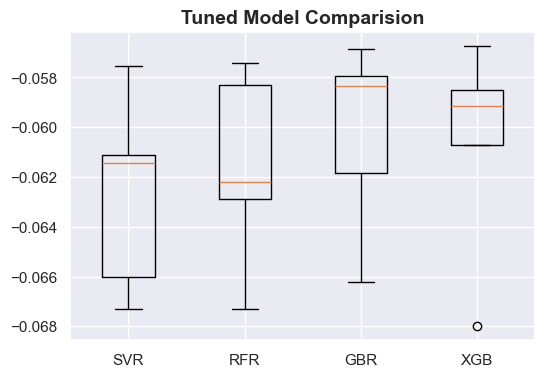

In [761]:
# Set plot size
plt.figure(figsize=(6,4))

# Plot accuracy scores using boxplots
plt.boxplot(tuned_results, labels=names)
plt.title("Tuned Model Comparision", fontsize=14, fontweight="bold")
plt.show()

# 8. Evaluation of Most Accurate Model

Since the best performing model on the optimal test split is presented below, further evaluation of this model will be conducted to ascertain its accuracy and efficacy.

In [764]:
print()
print("---" * 11)
print(f"Best Tuned Model Test Split: {BEST_TEST_SPLIT * 100}%")
print("---" * 11)
print(f"Best Performing Tuned Model: {most_accurate_model}")
print("---" * 11)
print()


---------------------------------
Best Tuned Model Test Split: 20.0%
---------------------------------
Best Performing Tuned Model: GBR
---------------------------------



### Fitting Best Model To Training Data

In [766]:
# Create dictionary of model classes
model_classes = {
    "XGB": XGBRegressor,
    "SVR": SVR,
    "RFR": RandomForestRegressor,
    "GBR": GradientBoostingRegressor
}

# Determine most accurate tuned model
for i in range(len(tuned_models)):
    if tuned_models[i][0] == most_accurate_model:
        most_accurate_params = optimised_hyperparameters[tuned_models[i][0]]

# Set up algorithm
best_model = model_classes[most_accurate_model](**most_accurate_params)

# Fit algorithm to training data
best_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.09816326530612245, n_estimators=50)

### Evaluate best model predictions using optimal test split

In [768]:
# Make predictions using trained algorithm on "unseen" 10% test split
y_pred = best_model.predict(X_test)

# Use mean absolute error to evaluate results
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred):.3f}")
print(f"Mean Absolute Percentage Error: {MAPE(y_test.values, y_pred)*100:.2f}%")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.3f}")
print(f"Root MSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}")

Mean Absolute Error: 0.047
Mean Absolute Percentage Error: 12.09%
Mean Squared Error: 0.003
Root MSE: 0.057


### Model Evaluation Plot

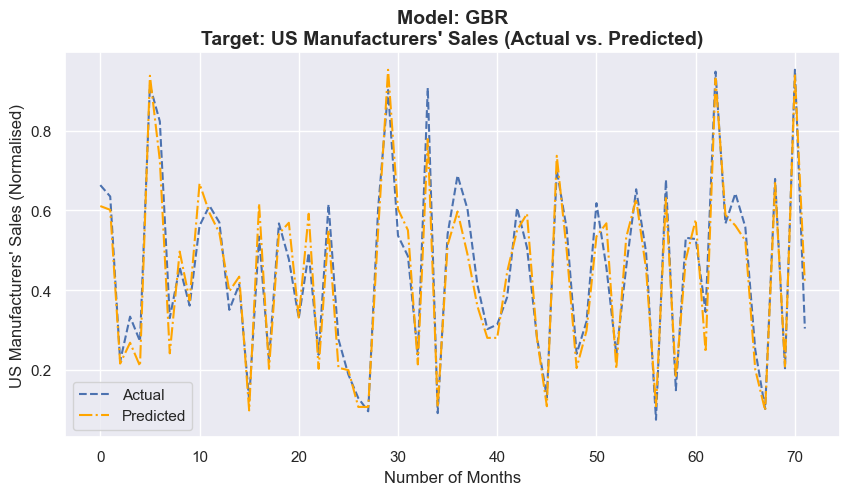

In [770]:
# Create figure to plot actual target values vs. predicted target values
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual", color="b", ls="--")
plt.plot(y_pred, label="Predicted", color="orange", ls="-.")
plt.legend(loc="best")
plt.title(f"Model: {most_accurate_model}\nTarget: US Manufacturers' Sales (Actual vs. Predicted)", fontsize=14, fontweight="bold")
plt.xlabel("Number of Months", fontsize=12)
plt.ylabel("US Manufacturers' Sales (Normalised)", fontsize=12)
plt.show()

### Residual Analysis of Best Model

In [772]:
print()
print("---" * 12)
print(f"Best Untuned Model Test Split: {BEST_TEST_SPLIT * 100}%")
print("---" * 12)
print(f"Best Tuned Model: {most_accurate_model}")
print("---" * 12)
print()


------------------------------------
Best Untuned Model Test Split: 20.0%
------------------------------------
Best Tuned Model: GBR
------------------------------------



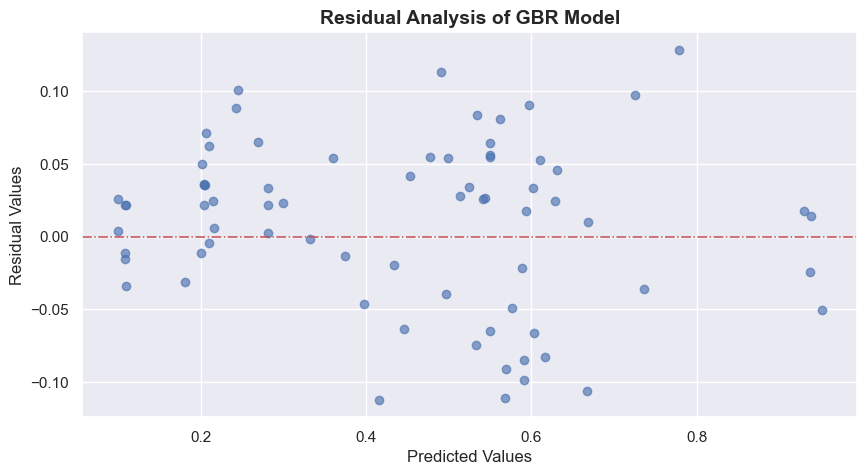

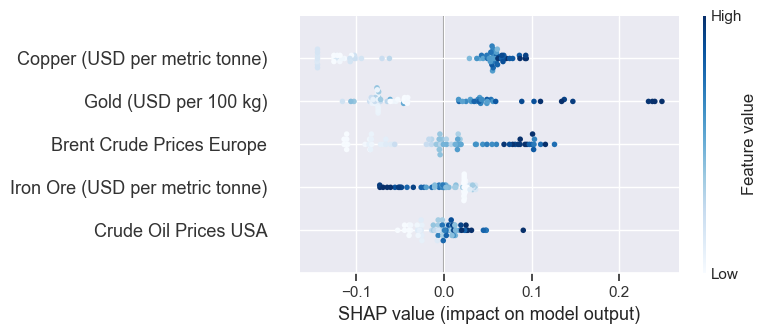

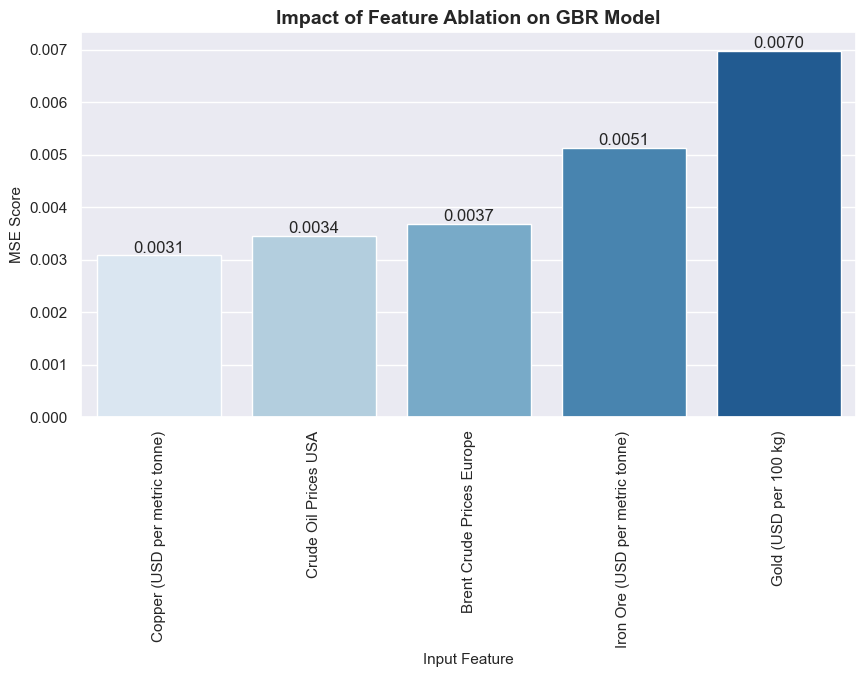

In [773]:
#------------------------------ RESIDUAL ANALYSIS --------------------------------------

# Calculate residuals
residuals = y_test - y_pred.ravel()

# Plot residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.65, color='b')
plt.axhline(y=0, color='r', linestyle='-.', lw=1.1)

plt.title(f"Residual Analysis of {most_accurate_model} Model", fontsize=14, fontweight="bold")
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residual Values", fontsize=12)

# Display scatter plot
plt.show()
print()

#---------------------------------- SHAP ANALYSIS -------------------------------------------

explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test, cmap="Blues")

# ------------------------------- FEATURE ABLATION -------------------------------------------

# Create dictionary to store MSE scores
mse_scores = dict()

for input_feature in X.columns:
    X_train_abn = X_train.drop(columns=[input_feature])
    X_test_abn = X_test.drop(columns=[input_feature])

    # Fit model to training data
    best_model.fit(X_train_abn, y_train)

    # Make predictions using ablated test set
    y_pred_abn = best_model.predict(X_test_abn)

    # Add MSE scores for ablated feature to dictionary
    mse_scores[input_feature] = mean_squared_error(y_test, y_pred_abn)

# Plot data stored in MSE dictionary 
sorted_mse_scores = dict(sorted(mse_scores.items(), key=lambda item: item[1]))

plt.figure(figsize=(10,5))
sns.barplot(x=list(sorted_mse_scores.keys()), y=list(sorted_mse_scores.values()), palette="Blues")

print()
plt.title(f"Impact of Feature Ablation on {most_accurate_model} Model", fontsize=14, fontweight="bold")
plt.xlabel("Input Feature", fontsize=11)
plt.xticks(rotation=90)
plt.ylabel("MSE Score", fontsize=11)

for i, mse_score in enumerate(sorted_mse_scores.values()):
    plt.text(i, mse_score, f"{mse_score:.4f}", ha="center", va="bottom")

# Display plot
plt.show()

# 9. Deep Learning Using TensorFlow

### Recurrent Neural Network (RNN)

In [776]:
# Create duplicate of data frame
_df = df.copy()

# Drop "Date" column 
_df.drop(["Date", "US Credit Card Rates (%)", "Global LNG Price", "Flexible Price CPI % Change"], axis=1, inplace=True)

# Normalise dataset using MinMaxScaler
scaler = MinMaxScaler()
normalised_df = pd.DataFrame(scaler.fit_transform(_df), columns=_df.columns)

# Convert normalised dataset into sequences that can be processed by RNN
# Define input features and target variable
X = normalised_df.iloc[:, :-1]
y = normalised_df.iloc[:, -1]

# Create sequences
def createRNNSequences(X, y, timeSteps):
    X_seq, y_seq = list(), list()
    for i in range(len(X) - timeSteps):
        X_seq.append(X.iloc[i:i+timeSteps].values)
        y_seq.append(y.iloc[i+timeSteps])
    return np.array(X_seq), np.array(y_seq)

# Call function to create sequences for X and y
time_steps = 10
X_seq, y_seq = createRNNSequences(X, y, time_steps)

# Split into training and test sets using 15% test size
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=BEST_TEST_SPLIT, random_state=12)

# Define RNN model
num_inputs = X.shape[1]

rnn_model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(time_steps, num_inputs)),
    Dense(1)
])

# Compile RNN model
rnn_model.compile(optimizer="adam", loss="mse")

# Train model
rnn_model.fit(X_train, y_train, epochs=50, batch_size=25, validation_data=(X_test, y_test), verbose=True)

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.2144 - val_loss: 0.0224
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0233 - val_loss: 0.0146
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0143 - val_loss: 0.0152
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0152 - val_loss: 0.0134
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0116 - val_loss: 0.0101
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0106 - val_loss: 0.0088
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - val_loss: 0.0083
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0084 - val_loss: 0.0080
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - val_

### Evaluation of RNN Model

In [778]:
# Make predictions using test set, X_test
y_pred = rnn_model.predict(X_test)

# Calculate evaluation metrics
mse = round(mean_squared_error(y_test, y_pred), 3)                 # Mean Squared Error
rmse = round(np.sqrt(mse), 3)                                      # Root Mean Squared Error
mae = round(mean_absolute_error(y_test, y_pred), 3)                # Mean Absolute Error
mape = round(np.mean(np.abs((y_test - y_pred) / y_test) * 100), 2) # Mean Absolute Percentage Error (MAPE)
r2 = round(r2_score(y_test, y_pred), 3)                            # R2 Score           

print("---" * 12)
print("Evaluation Metrics for RNN Model:")
print()
print(f"MSE: {mse: >8}")
print(f"RMSE: {rmse: >7}")
print(f"R2: {r2: >7} ({r2 * 100:.1f}%)")
print(f"MAPE: {mape: >7}%")
print("---" * 12)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
------------------------------------
Evaluation Metrics for RNN Model:

MSE:    0.005
RMSE:   0.071
R2:   0.893 (89.3%)
MAPE:   83.79%
------------------------------------


### RNN Evaluation Plot

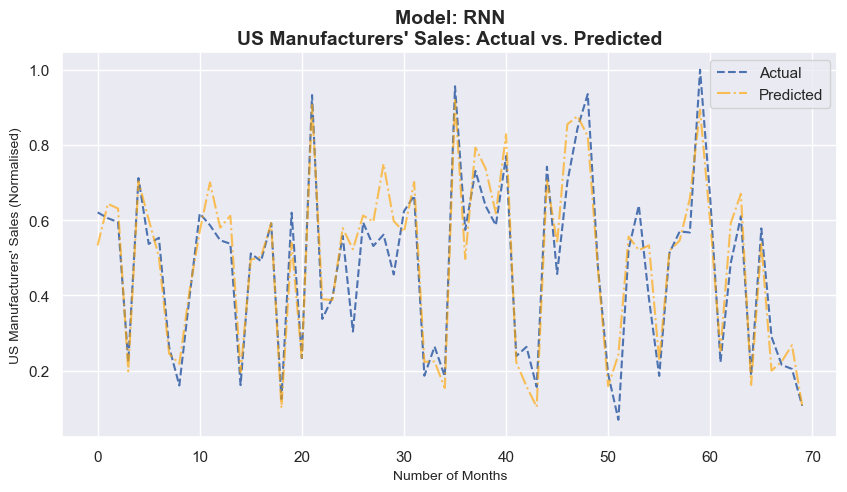

In [780]:
# Create figure to plot actual target values vs. predicted target values
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Actual", color="b", ls="--")
plt.plot(y_pred, label="Predicted", color="orange", ls="-.", alpha=0.65)
plt.legend(loc="best")
plt.title("Model: RNN\nUS Manufacturers' Sales: Actual vs. Predicted", fontsize=14, fontweight="bold")
plt.xlabel("Number of Months", fontsize=10)
plt.ylabel("US Manufacturers' Sales (Normalised)", fontsize=10)
plt.show()

### Residual Analysis of RNN Model

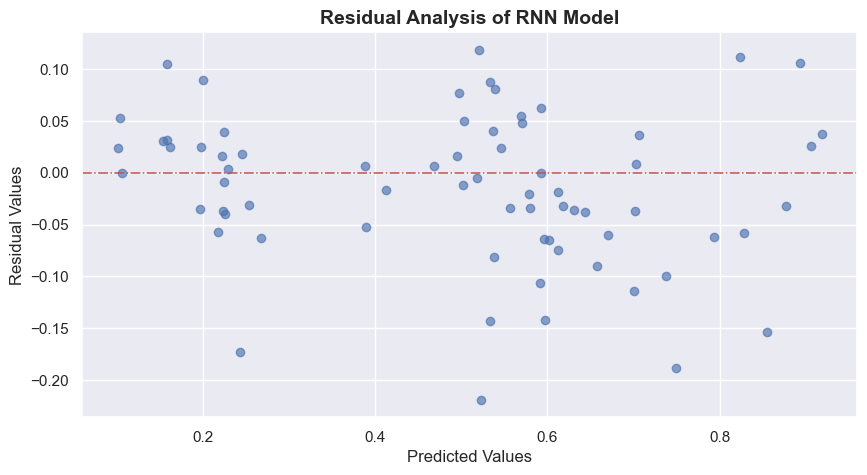

In [782]:
# Calculate residuals
residuals = y_test - y_pred.ravel()

# Plot residuals
plt.figure(figsize=(10, 5))
plt.scatter(y_pred, residuals, alpha=0.65, color='b')
plt.axhline(y=0, color='r', linestyle='-.', lw=1.1)

plt.title("Residual Analysis of RNN Model", fontsize=14, fontweight="bold")
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residual Values", fontsize=12)

# Display scatter plot
plt.show()
print()

### Impact of Feature Ablation on RNN Model Performance

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step


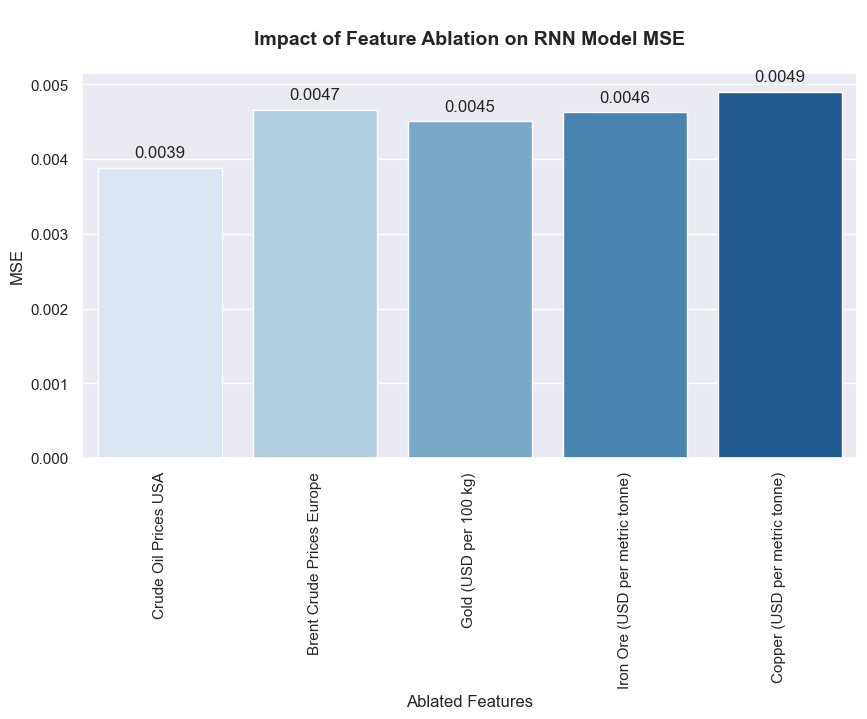

In [784]:
# Create dictionary to store feature ablation results
ablation_results = dict()

# Initialise time steps
time_steps = 10

model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(time_steps, num_inputs)),
    Dense(1)
])

# Compile RNN model
model.compile(optimizer="adam", loss="mse")

for feature in X.columns:
    # Drop selected feature 
    X_ablation = X.drop(feature, axis=1)

    # Create sequences for RNN model training
    X_seq_abn, y_seq_abn = createRNNSequences(X_ablation, y, time_steps)

    # Split normalised data into training and test sets (15% test set)
    X_train_abn, X_test_abn, y_train_abn, y_test_abn = train_test_split(X_seq_abn, y_seq_abn, test_size=0.15, random_state=12)

    # Re-define RNN model since one feature is dropped from original normalised X data
    num_inputs_abn = X_ablation.shape[1]
    rnn_model = Sequential([
        SimpleRNN(50, activation="relu", input_shape=(time_steps, num_inputs_abn)),
        Dense(1)
    ])

    # Compile re-defined model for each iteration
    rnn_model.compile(optimizer="adam", loss="mse")
    
    # Train RNN model using ablated X and y training sets
    rnn_model.fit(X_train_abn, y_train_abn, epochs=50, batch_size=10, verbose=False)

    # Evaluate model perform
    y_pred_abn = rnn_model.predict(X_test_abn)
    mse_abn = mean_squared_error(y_test_abn, y_pred_abn)

    # Store results in dictionary
    ablation_results[feature] = mse_abn

# Convert ablation_results dictionary to dataframe
abn_df = pd.DataFrame(list(ablation_results.items()), columns=["Ablated Feature", "MSE"])

# Create bar plot to visualise feature ablation results
plt.figure(figsize=(10, 5))
sns.barplot(data=abn_df, x="Ablated Feature", y="MSE", palette="Blues")

# Add MSE scores to bar plot
for index, row in abn_df.iterrows():
    plt.text(index, row["MSE"] + 0.0001, f"{row['MSE']:.4f}", ha="center", va="bottom")

plt.title("\nImpact of Feature Ablation on RNN Model MSE\n", fontsize=14, fontweight="bold")
plt.ylabel("MSE", fontsize=12)
plt.xlabel("Ablated Features", fontsize=12)
plt.xticks(rotation=90)
plt.show()

# 10. Model Development Using Lagged Time Series Dataset

In this section, the tuned model shown below will be trained using lagged normalised data. Model performance will then be evaluated.

In [787]:
print()
print("---" * 12)
print(f"Best Untuned Model Test Split: {BEST_TEST_SPLIT * 100}%")
print("---" * 12)
print(f"Best Tuned Model: {most_accurate_model}")
print("---" * 12)
print()


------------------------------------
Best Untuned Model Test Split: 20.0%
------------------------------------
Best Tuned Model: GBR
------------------------------------



------------------------
Evaluation Metrics:
MAE:   0.055
MSE:   0.005
RMSE:  0.071
MAPE:  26.0%
------------------------



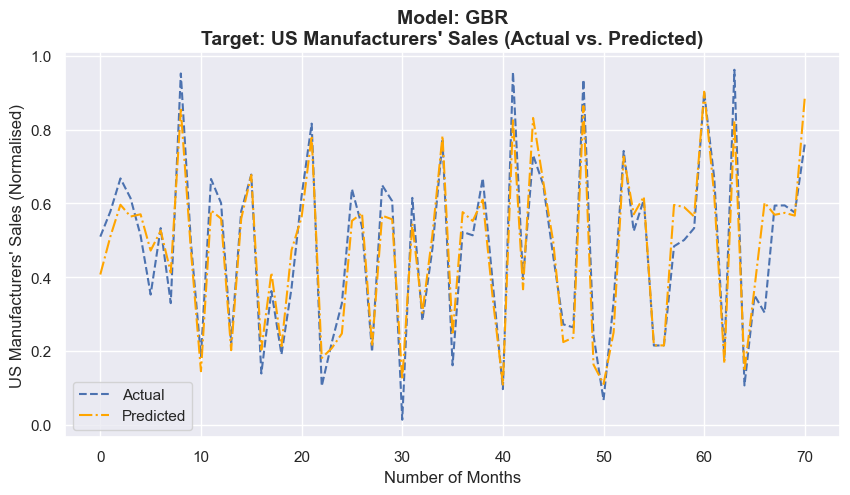

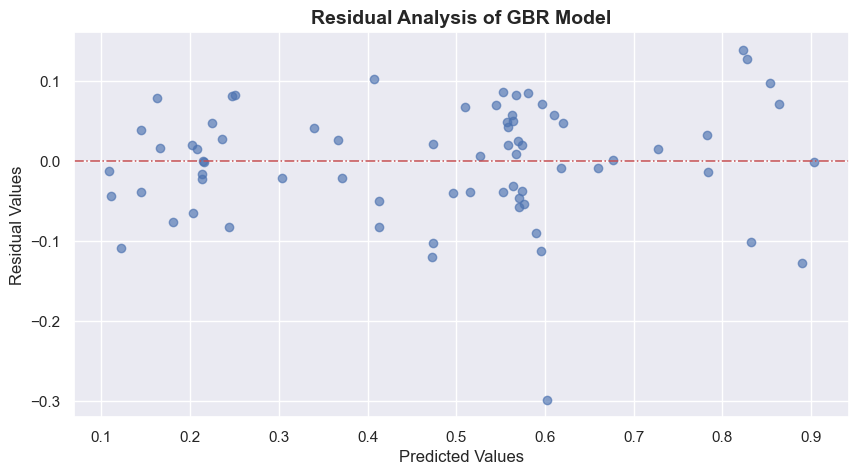

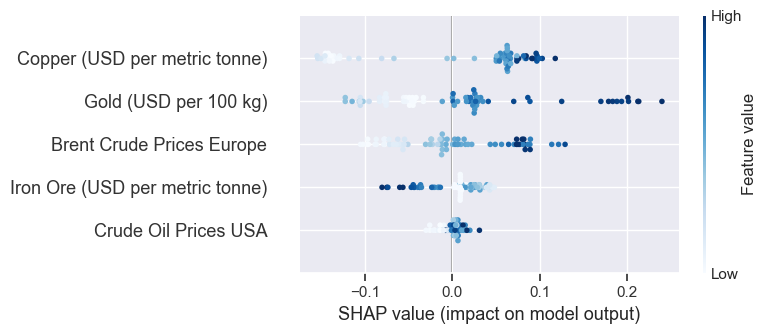

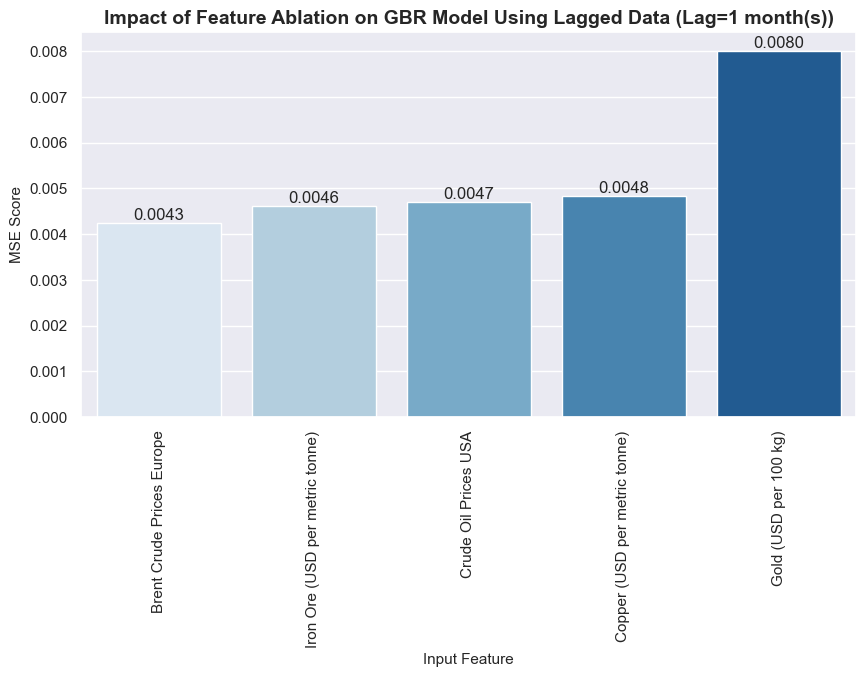

In [788]:
# Create duplicate of dataset
_df = df.copy()

# Drop unnecessary columns from dataset before normalising
_df.drop(columns=["Date", "US Credit Card Rates (%)", "Global LNG Price", "Flexible Price CPI % Change"], axis=1, inplace=True)

# Normalise all features using MinMaxScaler
scaler = MinMaxScaler()
normalised_df = pd.DataFrame(scaler.fit_transform(_df), columns=_df.columns)

# Adjust normalised dataset so that input features are lagged N months behind target variable
n_months = 1
lagged_df = normalised_df.drop(columns=["Manu Sales (USD, millions)"]).shift(n_months)
lagged_df = pd.concat([lagged_df, normalised_df["Manu Sales (USD, millions)"]], axis=1)
# Drop NaN values from re-constituted dataframe
lagged_df.dropna(inplace=True)

# Split lagged normalised data into input features and target variable
X = lagged_df.drop("Manu Sales (USD, millions)", axis=1)
y = lagged_df.iloc[:, -1]

# Create training and testing sets before on optimal test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=BEST_TEST_SPLIT, random_state=12)

# Set up tuned model before training
best_model = model_classes[most_accurate_model](**most_accurate_params)
best_model.fit(X_train, y_train)

# Make predictions and evaluate model performance
y_pred = best_model.predict(X_test)
mae = round(mean_absolute_error(y_test, y_pred), 3)
mse = round(mean_squared_error(y_test, y_pred), 3)
rmse = round(np.sqrt(mse), 3)
mape = round(np.mean(np.abs((y_test - y_pred) / y_test)) * 100, 1)

# Show evaluation metrics
print("---" * 8)
print("Evaluation Metrics:")
print(f"MAE: {mae: >7}")
print(f"MSE: {mse: >7}")
print(f"RMSE: {rmse: >6}")
print(f"MAPE: {mape: >5}%")
print("---" * 8)
print()

# Plot actual target values against model predicted target values
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual", color="b", ls="--")
plt.plot(y_pred, label="Predicted", color="orange", ls="-.")
plt.legend(loc="best")
plt.title(f"Model: {most_accurate_model}\nTarget: US Manufacturers' Sales (Actual vs. Predicted)", fontsize=14, fontweight="bold")
plt.xlabel("Number of Months", fontsize=12)
plt.ylabel("US Manufacturers' Sales (Normalised)", fontsize=12)
plt.show()
print()

# ---------------------------------- RESIDUAL ANALYSIS ------------------------------------------

# Calculate residuals
residuals = y_test - y_pred.ravel()

# Plot residuals
plt.figure(figsize=(10,5))
plt.scatter(y_pred, residuals, alpha=0.65, color='b')
plt.axhline(y=0, color='r', linestyle='-.', lw=1.1)

plt.title(f"Residual Analysis of {most_accurate_model} Model", fontsize=14, fontweight="bold")
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residual Values", fontsize=12)

# Display scatter plot
plt.show()
print()
print()

#---------------------------------- SHAP ANALYSIS -------------------------------------------

explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test, cmap="Blues")
print()

# ------------------------------- FEATURE ABLATION -------------------------------------------

# Create dictionary to store MSE scores
mse_scores = dict()

for input_feature in X.columns:
    X_train_abn = X_train.drop(columns=[input_feature])
    X_test_abn = X_test.drop(columns=[input_feature])

    # Fit model to training data
    best_model.fit(X_train_abn, y_train)

    # Make predictions using ablated test set
    y_pred_abn = best_model.predict(X_test_abn)

    # Add MSE scores for ablated feature to dictionary
    mse_scores[input_feature] = mean_squared_error(y_test, y_pred_abn)

# Plot data stored in MSE dictionary 
sorted_mse_scores = dict(sorted(mse_scores.items(), key=lambda item: item[1]))

plt.figure(figsize=(10,5))
sns.barplot(x=list(sorted_mse_scores.keys()), y=list(sorted_mse_scores.values()), palette="Blues")

print()
plt.title(f"Impact of Feature Ablation on {most_accurate_model} Model Using Lagged Data (Lag={n_months} month(s))", fontsize=14, fontweight="bold")
plt.xlabel("Input Feature", fontsize=11)
plt.xticks(rotation=90)
plt.ylabel("MSE Score", fontsize=11)

for i, mse_score in enumerate(sorted_mse_scores.values()):
    plt.text(i, mse_score, f"{mse_score:.4f}", ha="center", va="bottom")

# Display plot
plt.show()

### Filter Lagged Data By Year To Visualise Most Impactful Features

Filter normalised dataset lagged by 1 month(s) using following commodity prices:

['US Credit Card Rates (%)', 'Crude Oil Prices USA', 'Brent Crude Prices Europe', 'Global LNG Price', 'Flexible Price CPI % Change', 'Gold (USD per 100 kg)', 'Iron Ore (USD per metric tonne)', 'Copper (USD per metric tonne)', 'Manu Sales (USD, millions)']



Enter year to filter lagged dataset:  1998
Enter first lagged feature:  Gold (USD per 100 kg)
Enter second lagged feature:  Copper (USD per metric tonne)
Enter target feature (unlagged):  Manu Sales (USD, millions)


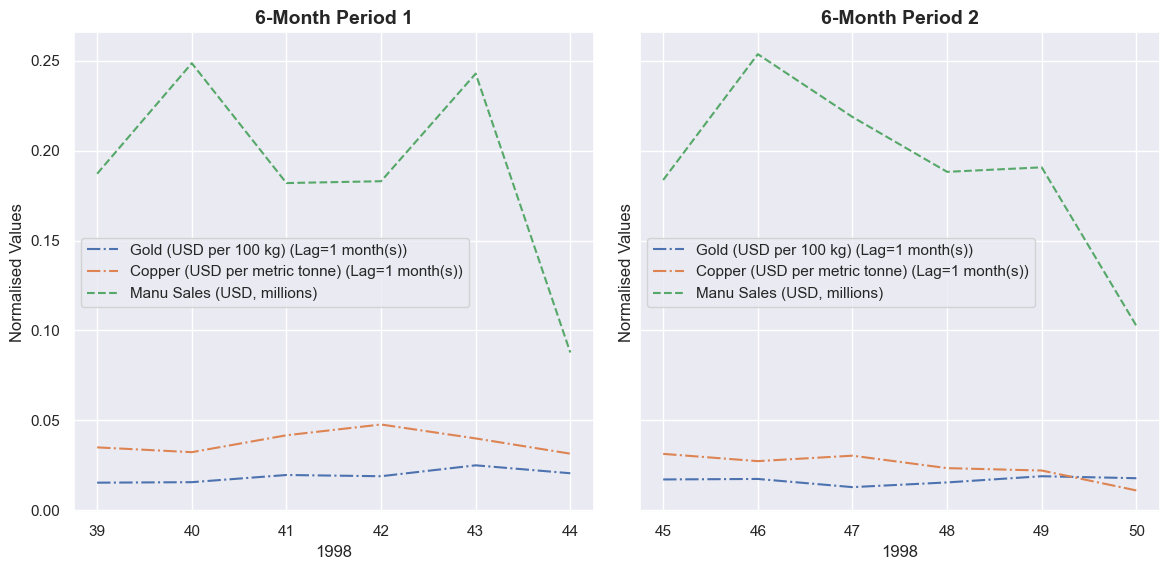

In [790]:
# Define constant for lag (months)
N_MONTHS = 1

# Create duplicate of dataset
df_copy = df.copy()

# Reset index
df_copy = df_copy.reset_index()

# Assign "Date" column to variable
date_col = df_copy["Date"]

# Drop unnecessary columns from dataset before normalising
df_copy.drop(columns=["Date", "US Credit Card Rates (%)", "Global LNG Price", "Flexible Price CPI % Change"], axis=1, inplace=True)

# Normalise all features using MinMaxScaler (excluding "Date" column)
scaler = MinMaxScaler()
normalised_df = pd.DataFrame(scaler.fit_transform(df_copy), columns=df_copy.columns)

# Re-attach "Date" column to normalised data
normalised_df["Date"] = pd.to_datetime(date_col)

# After re-setting index, remove "index" column
normalised_df.drop(columns=["index"], inplace=True)

# Convert "Date" to datetime object
normalised_df["Date"] = pd.to_datetime(normalised_df["Date"])

# Filter lagged normalised dataset by selected year and input features
print(f"Filter normalised dataset lagged by {N_MONTHS} month(s) using following commodity prices:\n")
print(df.columns.to_list()[1:])
print()
selected_year = int(input("Enter year to filter lagged dataset: "))
input_feature1 = input("Enter first lagged feature: ")
input_feature2 = input("Enter second lagged feature: ")
target_var = input("Enter target feature (unlagged): ")
print()

# Adjust normalised dataset so that input features are lagged N months behind target variable
lagged_df = normalised_df.drop(columns=[target_var]).shift(N_MONTHS)
lagged_df = pd.concat([lagged_df, normalised_df[target_var]], axis=1)
# Drop NaN values from re-constituted dataframe
lagged_df.dropna(inplace=True)

# Filter lagged normalised dataset by selected year
year_data = lagged_df.loc[lagged_df["Date"].dt.year == selected_year]

# Create list of input features to compare against target variable
selected_lagged_features = [input_feature1, input_feature2]

# Generate line plots based on input features per 6 months
selected_6mths = [year_data.iloc[i:i+6] for i in range(0, len(year_data),6)]
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharey=True)

for i, p in enumerate(selected_6mths[:2]):
    # Define axes coordinates - 1D array
    ax = axes[i]
    # Plot lagged input features
    for input_feature in selected_lagged_features:
        ax.plot(p.index, p[input_feature], label=f"{input_feature} (Lag={N_MONTHS} month(s))", ls="-.", lw=1.5)
    # Plot target variable
    ax.plot(p.index, p[target_var], label=f"{target_var}", ls="--", lw=1.5)
    ax.set_title(f"6-Month Period {i+1}", fontsize=14, fontweight="bold")
    ax.set_xlabel(f"{selected_year}", fontsize=12)
    ax.set_ylabel("Normalised Values", fontsize=12)
    ax.legend(loc="best")

# Define layout for entire plot
plt.tight_layout(pad=1.5)
plt.show()

*** End of Script ***